In [168]:
# Import custom helper libraries
import os
import sys

# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# System modules
import time
import random
import requests
from hashlib import md5
import json


# ML modules
import pandas as pd
import numpy as np
import seaborn as sns

from utils import *

import string

# Sample data for development
TEXT_SAMPLE_SIZE = 10 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 20 * 1000  # <= 0 for all

# NLTK
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

import spacy

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler



#Clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [169]:
#nltk.download('omw-1.4')

In [170]:
# Download SpaCy model make in the command promt
# python -m spacy download en_core_web_sm 

In [171]:
nlp = spacy.load("en_core_web_sm")

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bartcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bartcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Review dataset

In [172]:
if os.path.exists("data/processed/reviews.pkl.gz"):
    logger.info(">>> Loading reviews from pickle file...")
    reviews_df = pd.read_pickle("data/processed/reviews.pkl.gz")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from pickle file.")
else:
    # Load academic data from row CSV file
    logger.info(">>> Loading reviews from JSON file...")
    reviews_df = pd.DataFrame()
    with pd.read_json(
        "data/yelp_dataset/yelp_academic_dataset_review.json",
        dtype={
            "review_id": str,
            "user_id": str,
            "business_id": str,
            "stars": int,
            "useful": int,
            "funny": int,
            "cool": int,
            "text": str,
            "date": "datetime64[ns]",
        },
        chunksize=500 * 1000,
        lines=True,
    ) as json_reader:
        # Load data in chunks
        for chunk in json_reader:
            reviews_df = reviews_df.append(chunk)
            logger.info(f"Loaded {len(reviews_df)} reviews")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from JSON file.")

    # Reduce memory usage
    reviews_df = reduce_dataframe_memory_usage(reviews_df)

    # Save as pickle
    logger.info(">>> Saving reviews data as pickle file...")
    os.makedirs("data/processed/", exist_ok=True)
    reviews_df.to_pickle("data/processed/reviews.pkl.gz")
    logger.info(
        ">>> OK : Reviews data saved to data/processed/reviews.pkl.gz ."
    )

if TEXT_SAMPLE_SIZE > 0:
    # Sample data
    logger.info(">>> Sampling reviews data...")
    reviews_df = reviews_df.sample(TEXT_SAMPLE_SIZE, random_state=1)
    logger.info(f">>> OK : Data sampled to {len(reviews_df)} reviews.")

INFO:__main__:>>> Loading reviews from pickle file...
INFO:__main__:>>> OK : 6990280 reviews loaded from pickle file.
INFO:__main__:>>> Sampling reviews data...
INFO:__main__:>>> OK : Data sampled to 10000 reviews.


In [173]:
reviews_df.head()

review_id                 user_id  \
5095865  grCKx4FxYyUwdnOBhQfX0g  JfmoxgXfQ0Ry0p9BpUeiuw   
5738483  AcEJifrPG10UuFL4U5PatQ  FIGKtYfnOf9lulst6SfYHA   
1759834  DuTIRuFSQyfNHvaWuB7IOw  PAhPFMahii5gfB3WSDX0DQ   
5208919  snT2LwnMGFYQBIj9QvaL_Q  fJhQQKVrq2z_01PVEEDW4g   
4569498  PlgTJzVt7-6-fVPFxJ0R-A  rmYFZaQsJiBrmuGY6DfzRg   

                    business_id  stars  useful  funny  cool  \
5095865  wX4ap0Qy5ZK6Hy2iKvBqXA      5       0      0     0   
5738483  vYRqUvqE7T7rnHjLjTB2tQ      5       1      0     0   
1759834  nCqQf0L0GsVHxub7BDESaA      1       0      0     0   
5208919  AWcelHEIYKzk348Q2htKmQ      5       0      0     0   
4569498  WtuSRpjR3aI_3Y7t9YwR2Q      5       0      0     0   

                                                      text                date  
5095865  Some of the best Italian I've had anywhere. Ev... 2014-09-23 01:07:43  
5738483  Excellent food, wonderful nice staff. The Pho ... 2016-02-29 23:58:37  
1759834  Super slow service. Place was not busy Food wa... 2019-02-15 16:18:20  
5208919  This YMCA is top of the line!  It is only a li... 2013-01-22 16:06:57  
4569498  Walked in and got Lucy. She was wonderful. I w... 2019-03-22 21:55:56

In [174]:
reviews_df = reviews_df.reset_index(drop=True)

## EDA

In [175]:
reviews_df.describe()

stars        useful         funny          cool
count  10000.000000  10000.000000  10000.000000  10000.000000
mean       3.738500      1.171700      0.300800      0.478000
std        1.482005      2.760685      1.306863      1.781469
min        1.000000      0.000000      0.000000      0.000000
25%        3.000000      0.000000      0.000000      0.000000
50%        4.000000      0.000000      0.000000      0.000000
75%        5.000000      1.000000      0.000000      0.000000
max        5.000000     95.000000     52.000000     95.000000

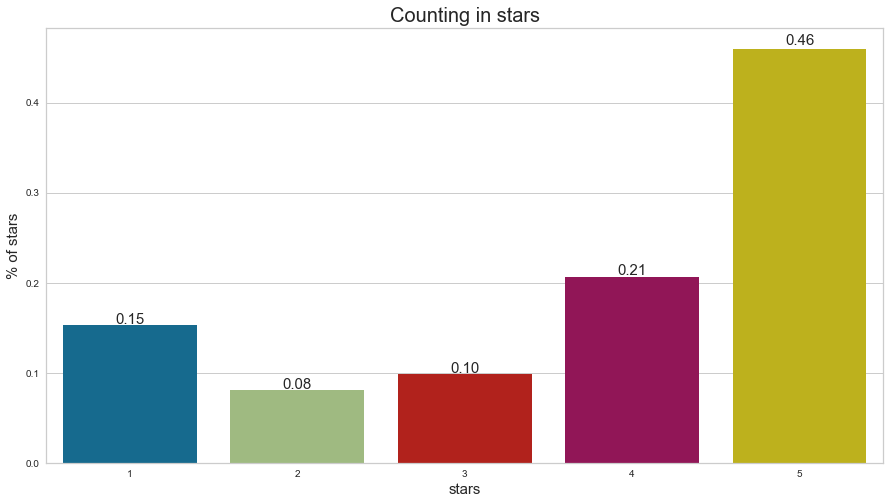

In [176]:
plot_count_col(reviews_df, col= 'stars', label_col='stars', show_val=True)

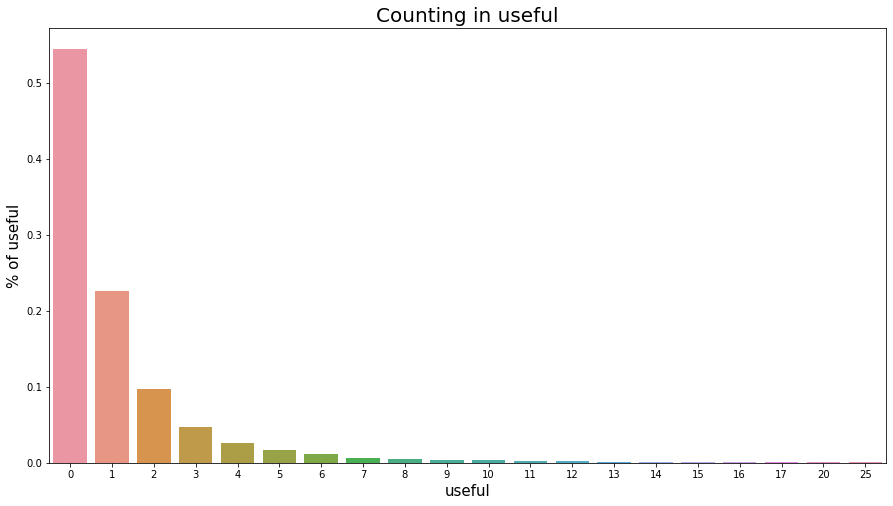

In [26]:
plot_count_col(reviews_df, col= 'useful', label_col='useful', show_val=False, top=20)

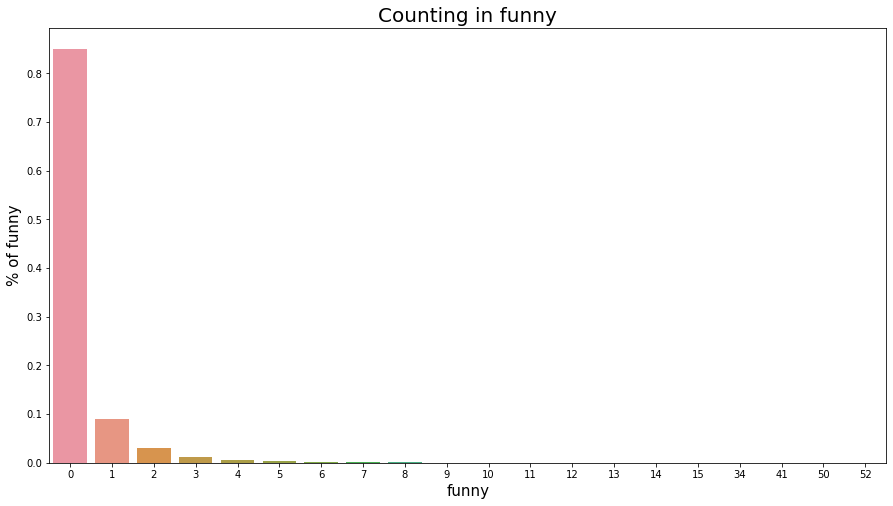

In [27]:
plot_count_col(reviews_df, col= 'funny', label_col='funny', show_val=False)

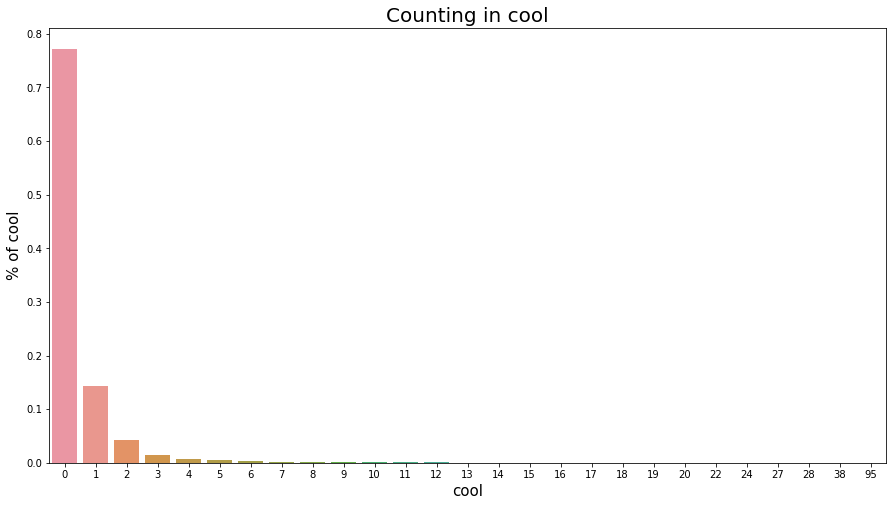

In [28]:
plot_count_col(reviews_df, col= 'cool', label_col='cool', show_val=False)

In [29]:
reviews_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

***How much reviews per user***

In [30]:
reviews_df.groupby('user_id').agg('count')

review_id  business_id  stars  useful  funny  cool  \
user_id                                                                      
--9jUPPYMRSnJKlOskyyDA          1            1      1       1      1     1   
-02tzlpQosZ9HE85jEtV6Q          1            1      1       1      1     1   
-0KrCHEsOcjJ6N4k_k1A9A          1            1      1       1      1     1   
-0mrmedVkALZ0w-wROseZQ          1            1      1       1      1     1   
-1XU-0De2TKEwNRmmRU2KA          1            1      1       1      1     1   
...                           ...          ...    ...     ...    ...   ...   
zy3gG5D284CRO9Rsd4trFg          1            1      1       1      1     1   
zzBhA0M7NNBMYoWj48h53A          1            1      1       1      1     1   
zzUKixXipsKL-bzTQ2wwPw          1            1      1       1      1     1   
zzsekNWqIZ42c2TZQaTPhw          1            1      1       1      1     1   
zztkCqqgR6VntYbqio4UTQ          1            1      1       1      1     1   

                        text  date  
user_id                             
--9jUPPYMRSnJKlOskyyDA     1     1  
-02tzlpQosZ9HE85jEtV6Q     1     1  
-0KrCHEsOcjJ6N4k_k1A9A     1     1  
-0mrmedVkALZ0w-wROseZQ     1     1  
-1XU-0De2TKEwNRmmRU2KA     1     1  
...                      ...   ...  
zy3gG5D284CRO9Rsd4trFg     1     1  
zzBhA0M7NNBMYoWj48h53A     1     1  
zzUKixXipsKL-bzTQ2wwPw     1     1  
zzsekNWqIZ42c2TZQaTPhw     1     1  
zztkCqqgR6VntYbqio4UTQ     1     1  

[9706 rows x 8 columns]

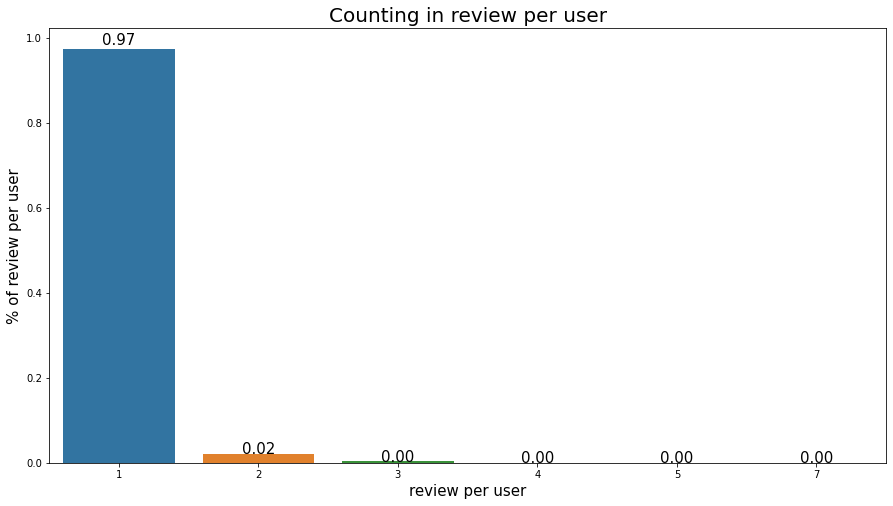

In [31]:
plot_count_col(reviews_df.groupby('user_id').agg('count'), col= 'review_id', label_col='review per user', show_val=True)

97% of users gived just 1 review.

***How much bussiness per review?***

In [32]:
reviews_df.groupby('business_id').agg('count')

review_id  user_id  stars  useful  funny  cool  text  \
business_id                                                                    
-0G_6-KFGpCpxTUlVXCMYQ          2        2      2       2      2     2     2   
-0TffRSXXIlBYVbb5AwfTg          3        3      3       3      3     3     3   
-0gRYq5UjMtZbELj0KHxzA          2        2      2       2      2     2     2   
-1XSzguS6XLN-V6MVZMg2A          1        1      1       1      1     1     1   
-1q3O9hvYmrELU39_Thbzw          1        1      1       1      1     1     1   
...                           ...      ...    ...     ...    ...   ...   ...   
zxIF-bnaJ-eKIsznB7yu7A          3        3      3       3      3     3     3   
zxuVnNVAUm16Sro0dS_lmg          1        1      1       1      1     1     1   
zyFlGv7TXKquCmXrC8cp4Q          1        1      1       1      1     1     1   
zz07slKrNwzX_1uiF8QL6g          1        1      1       1      1     1     1   
zz3E7kmJI2r2JseE6LAnrw          1        1      1       1      1     1     1   

                        date  
business_id                   
-0G_6-KFGpCpxTUlVXCMYQ     2  
-0TffRSXXIlBYVbb5AwfTg     3  
-0gRYq5UjMtZbELj0KHxzA     2  
-1XSzguS6XLN-V6MVZMg2A     1  
-1q3O9hvYmrELU39_Thbzw     1  
...                      ...  
zxIF-bnaJ-eKIsznB7yu7A     3  
zxuVnNVAUm16Sro0dS_lmg     1  
zyFlGv7TXKquCmXrC8cp4Q     1  
zz07slKrNwzX_1uiF8QL6g     1  
zz3E7kmJI2r2JseE6LAnrw     1  

[8373 rows x 8 columns]

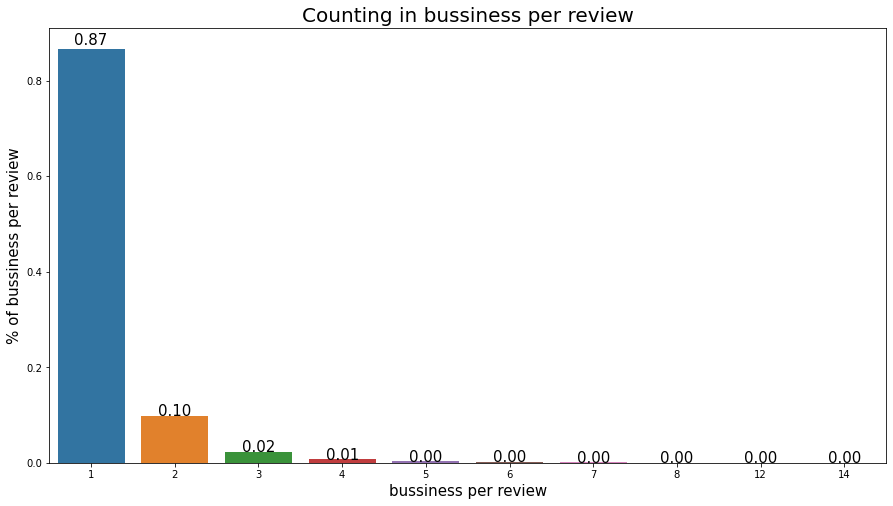

In [33]:
# Number of reviews per business
plot_count_col(reviews_df.groupby('business_id').agg('count'), col= 'review_id', label_col='bussiness per review', show_val=True)

87% of bussiness has 1 review, 2 reviews has 10% of bussienss, 3 reviews has 2 % of bussienss, 5 and more reviews has less then 1% of bussiness.

***How much review per star?***

In [34]:
reviews_df.groupby('stars').agg('count').review_id

stars
1    1534
2     813
3     987
4    2066
5    4600
Name: review_id, dtype: int64

One can see that the highest number of review is for the star equat to 5. 

In [35]:
reviews_df.groupby('stars').agg('max')[['useful', 'funny', 'cool']]

useful  funny  cool
stars                     
1          95     34    27
2          18     12    12
3          39     50    38
4          27     15    28
5          92     52    95

One can see that the most useful review are with stars 1 and 5. Also reviews with stars 5 are the funniest and the coolest.

Let us see if there are missing values in the reviews:

In [36]:
missing_values_table(reviews_df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Also let us see if there are review text that does not contains any text.

In [37]:
reviews_df[reviews_df.text=='']

Empty DataFrame
Columns: [review_id, user_id, business_id, stars, useful, funny, cool, text, date]
Index: []

## Defining negative comments - sentiment analysis

In [177]:
#from sklearn.model_selection import train_test_split


X = reviews_df["text"]
y = reviews_df["stars"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


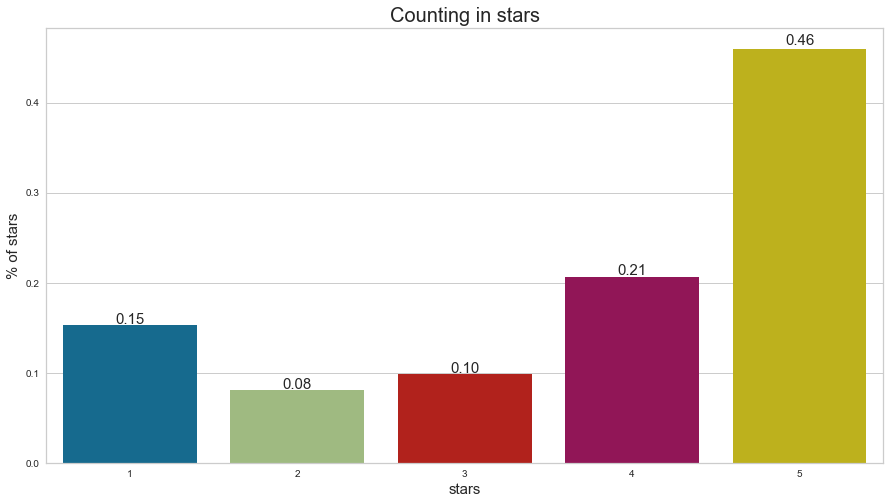

In [178]:
plot_count_col(reviews_df, 'stars', label_col='stars', show_val = True, on_x=True)

***Binary segmentation:*** We can see that we have more positive reviews than negative ones. Let us assume that 1, 2 stars are review that are associated with negative sentiments, 3, 4, 5 are associated with positive sentiments.

In [179]:
reviews_df.loc[:,'sentiment'] = 1
reviews_df.loc[reviews_df.stars<3, 'sentiment']=0

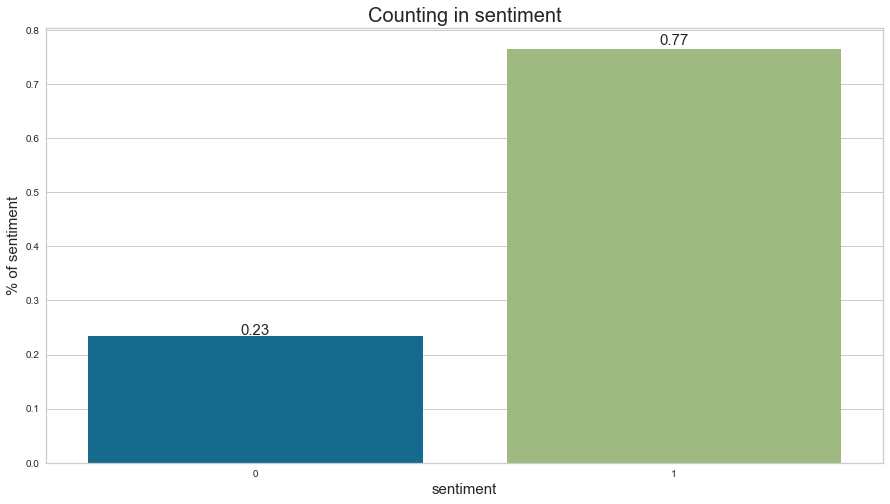

In [180]:
plot_count_col(reviews_df, 'sentiment', label_col='sentiment', show_val = True, on_x=True)

In [181]:
reviews_df.sentiment.value_counts()

1    7653
0    2347
Name: sentiment, dtype: int64

Here we can see that 23% of data are with negative sentiments and 77% of data are with positive sentiments.

In [182]:
X = reviews_df[reviews_df.sentiment==0].reset_index(drop=True).text

## Peprocess and set Features Bag of words

In [183]:
def preprocess_text2(text):
    text = text.lower()
    #text = word_tokenize(text)
    text = nlp(text)
    
    tokens = [token.lemma_ for token in text if
              (not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
              and not token.is_stop
              and not token.like_num
              and not token.pos_ == "PROPN"
              )]
    
    # Initialize a stemmer
    ps = PorterStemmer()
    # and stem (remove suffix of the word)
    tokens = [ps.stem(tk) for tk in tokens]
    
    tokens = [t for t in tokens if t in wordnet.words()] # verify if the word exists in the wordnet
    
    
    text = set(tokens) - stopwords
    
    return text

In [184]:
def preprocess_text(text):
    text = text.lower()
    #text = word_tokenize(text)
    text = nlp(text)
    
    tokens = [token.lemma_ for token in text if
              (not token.is_punct
              and not token.is_currency
              and not token.is_digit
              and not token.is_punct
              and not token.is_space
              and not token.is_stop
              and not token.like_num
              and not token.pos_ == "PROPN"
              )]
    
    # Initialize a stemmer
    ps = PorterStemmer()
    # and stem (remove suffix of the word)
    tokens = [ps.stem(tk) for tk in tokens]
    
    tokens = [t for t in tokens if t in wordnet.words()] # verify if the word exists in the wordnet
    
    
    text = set(tokens) - stopwords
    
    return ' '.join(text)

In [185]:
X

0       Super slow service. Place was not busy Food wa...
1       If my employer didn't make me use this pharmac...
2       If you need food items go to Whole Foods or ea...
3       Not up to the standards of a true Aveda salon....
4       I was here over Memorial Day weekend with frie...
                              ...                        
2342    Their bagels are good, but the service here te...
2343    Horrible service! All women are very arrogant ...
2344    let's name a restaurant kindness and paint the...
2345    Still waiting for a call back from their sched...
2346    We had a less than pleasant experience at Simm...
Name: text, Length: 2347, dtype: string

In [186]:
import dask.dataframe as dd

ddf = dd.from_pandas(X, npartitions=30) # find your own number of partitions
ddf_update = ddf.apply(lambda x: preprocess_text(x), meta=ddf)

#res = ds.apply(lambda x: x + 1, meta=ds)

In [187]:
Y = ddf_update.compute() # getting the dataframe from dask

In [188]:
Y

0                         place cold poor super food slow
1       confirm area med spell drive away tell play we...
2       beach think yelp fare live item size check foo...
3       stylist good interest hair true thing color la...
4       crab end bake rib wonder good hand stick tell ...
                              ...                        
2342    feel good slow review order wrong like liter r...
2343    woman area owner bad talk nail polish high go ...
2344         paint kind food let build concept black rude
2345        hour callback go voicemail number depart wait
2346    verbal begin current owner action give feel fi...
Name: text, Length: 2347, dtype: object

In [189]:
word_count = pd.DataFrame(pd.DataFrame(Y).text.str.split(expand=True).stack().value_counts())
word_count = word_count.reset_index()
word_count.columns=['word', 'count']
word_count

word  count
0         time    818
1         food    817
2        place    792
3        order    733
4         come    726
...        ...    ...
4182    causal      1
4183     trout      1
4184     kaput      1
4185  lamppost      1
4186        20      1

[4187 rows x 2 columns]

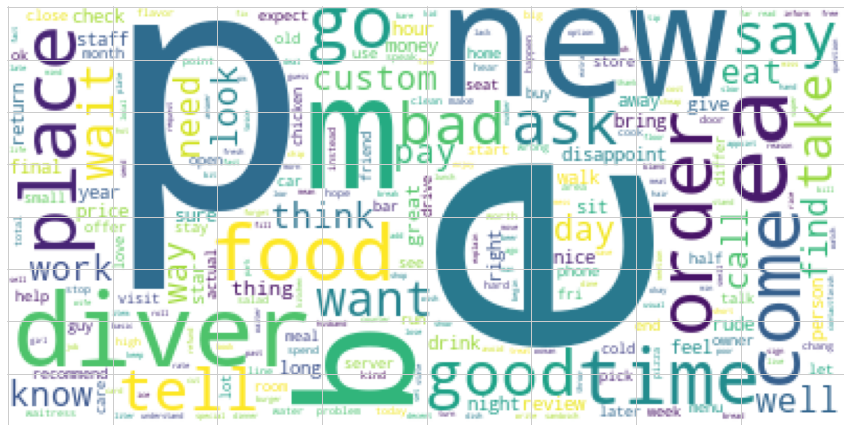

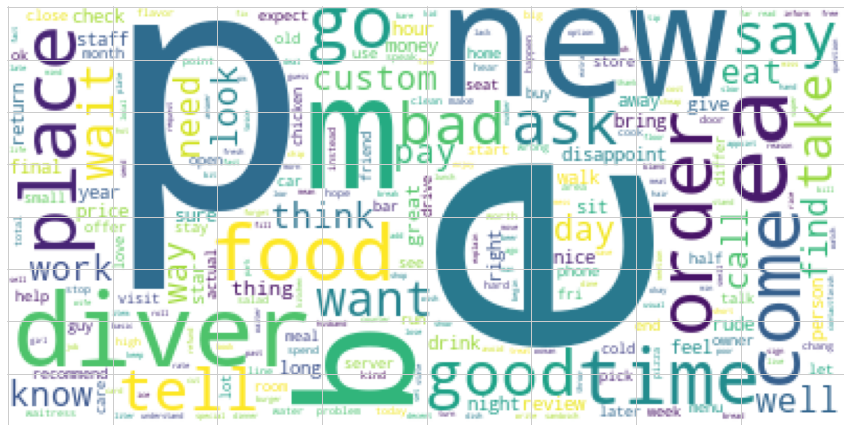

In [190]:
plot_words(word_count, col='word', height = 15, wieght = 10)

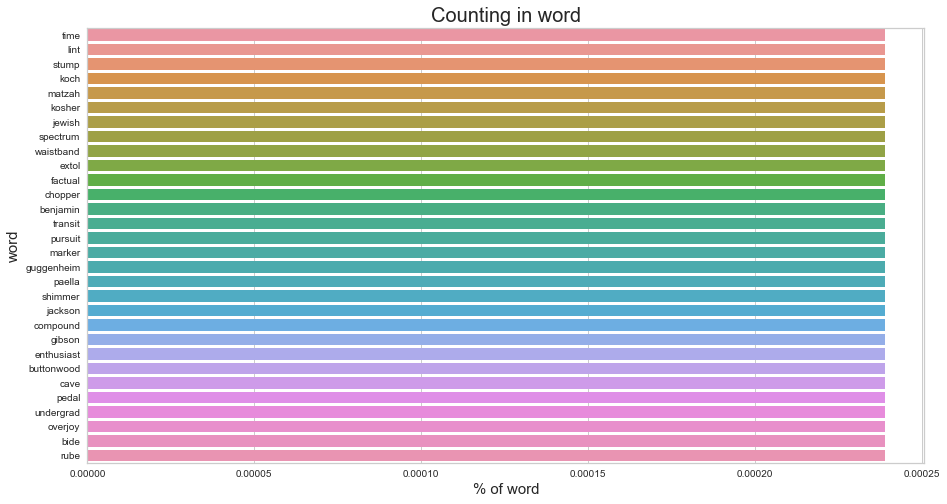

In [191]:
plot_count_col(word_count, 'word', label_col='word', show_val = False, on_x=False, top=30)

In [192]:
vectorizers = [CountVectorizer(), #0
               TfidfVectorizer(), #1 not very satisfying
               CountVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word'), #2
               CountVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               ngram_range=(1,2)),#3
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_df=0.9,
                               min_df=0.01),#4
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_df=0.9,
                               min_df=0.01,
                               ngram_range=(1,2)),#5
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word'),#6  not very satisfying
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_features=1000),#7
               TfidfVectorizer(strip_accents="unicode", 
                               lowercase=True, 
                               stop_words='english', 
                               analyzer='word', 
                               max_df=0.9,
                               min_df=0.01,
                               ngram_range=(1,2),
                               max_features=1000),#8
               ]

In [196]:
#index = 5
with timer("Data vectorization"):
    X_v = {}
    df_nlp_review = {}
    for index, vect in enumerate(vectorizers):
        X_v[index] = {}
        X_v[index]['vect'] = vect.fit_transform(Y)
        X_v[index]['feature_names'] = vect.get_feature_names()#to get the names of the tokens
        dense = X_v[index]['vect'].todense() #convert sparse matrix to numpy array
        denselist = dense.tolist() #convert array to List
        df_nlp_review[index] = pd.DataFrame(denselist, columns=X_v[index]['feature_names']) #convert to dataframe

Data vectorization - done in 18s


In [206]:
df_nlp_review[index].to_pickle("data/processed/df_nlp_review.pkl.gz")

In [197]:
index = 5
words_count = pd.DataFrame(
        data = np.column_stack((X_v[index]['feature_names'], X_v[index]['vect'].sum(axis=0).tolist()[0])) ,
    columns=['word', 'freq']
)

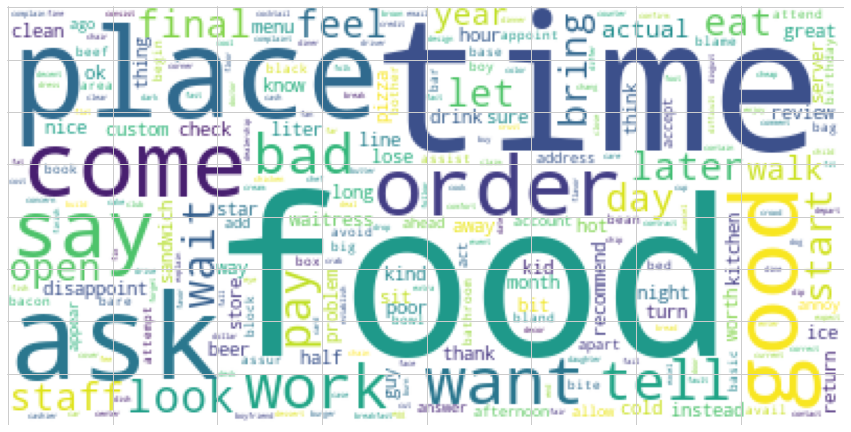

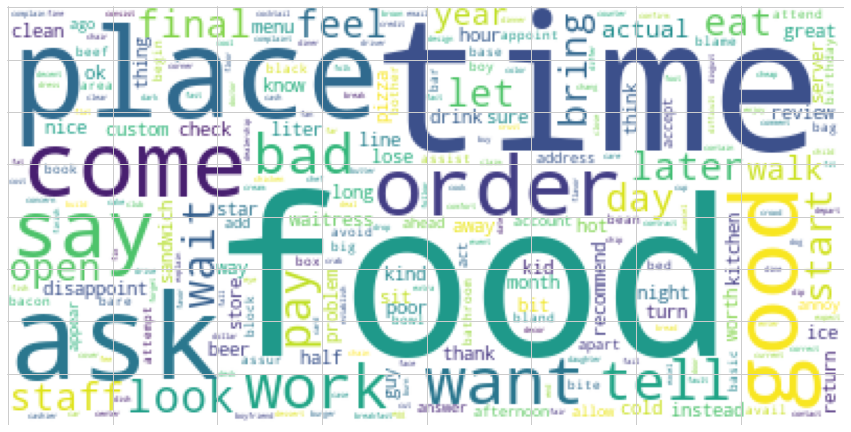

In [198]:
plot_words(words_count, col='word', height = 15, wieght = 10)

## Topic analysis

Here we will analise the topics of the reviews in ordrer to understand better the satisfaction or insatisfaction of clients. 

We use different technics to indentify the topics. The one that is the most pertinent will be preserved and disscussed.

 - LSA : Latent Semantic Analysis (LSA) is a method for dimensionality reduction. It is a supervised method that uses a matrix decomposition to project the data into a lower dimensional space.
 - LDA : Latent Dirichlet Allocation (LDA) is a probabilistic model that uses a probabilistic graphical model to infer the topic distribution of a document.
 - NMF: Non-Negative Matrix Factorization (NMF). Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [227]:
n_topics = 10 # number of choosen topics
no_top_words = 10 # number of top words to show per topic

In [200]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    n_cols = 5
    n_lines = int(np.ceil(min(n_topics, model.n_components) / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [201]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LSA

In [202]:
from sklearn.decomposition import TruncatedSVD
# Fit the LSA model
logging.info(
    "Fitting the LSA model with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (df_nlp_review[index].shape[0], df_nlp_review[index].shape[1])
)
with timer("creation and fitting lsa model"):
    lsa = TruncatedSVD(n_components=n_topics, random_state=1)
    lsa.fit_transform(df_nlp_review[index])

INFO:root:Fitting the LSA model with tf-idf features, n_samples=2347 and n_features=648...


creation and fitting lsa model - done in 0s


In [203]:
display_topics(lsa, X_v[index]['feature_names'], no_top_words)

Topic 0:
food place time order come good like bad tell ask
Topic 1:
food order eat good chicken fri meal drink flavor disappoint
Topic 2:
wait order time hour ask come food seat waitress food time
Topic 3:
bad custom food rude good bad food food time place good bad staff
Topic 4:
place wait hour staff bar room seat drink long stay
Topic 5:
rude staff ask stay eat custom walk bad room away
Topic 6:
wait place hour like order bad pizza eat stay room
Topic 7:
bad come review bad food year good bad month night stay ago
Topic 8:
place time want time come like star come know like want money
Topic 9:
food time time rude money food staff like order save year


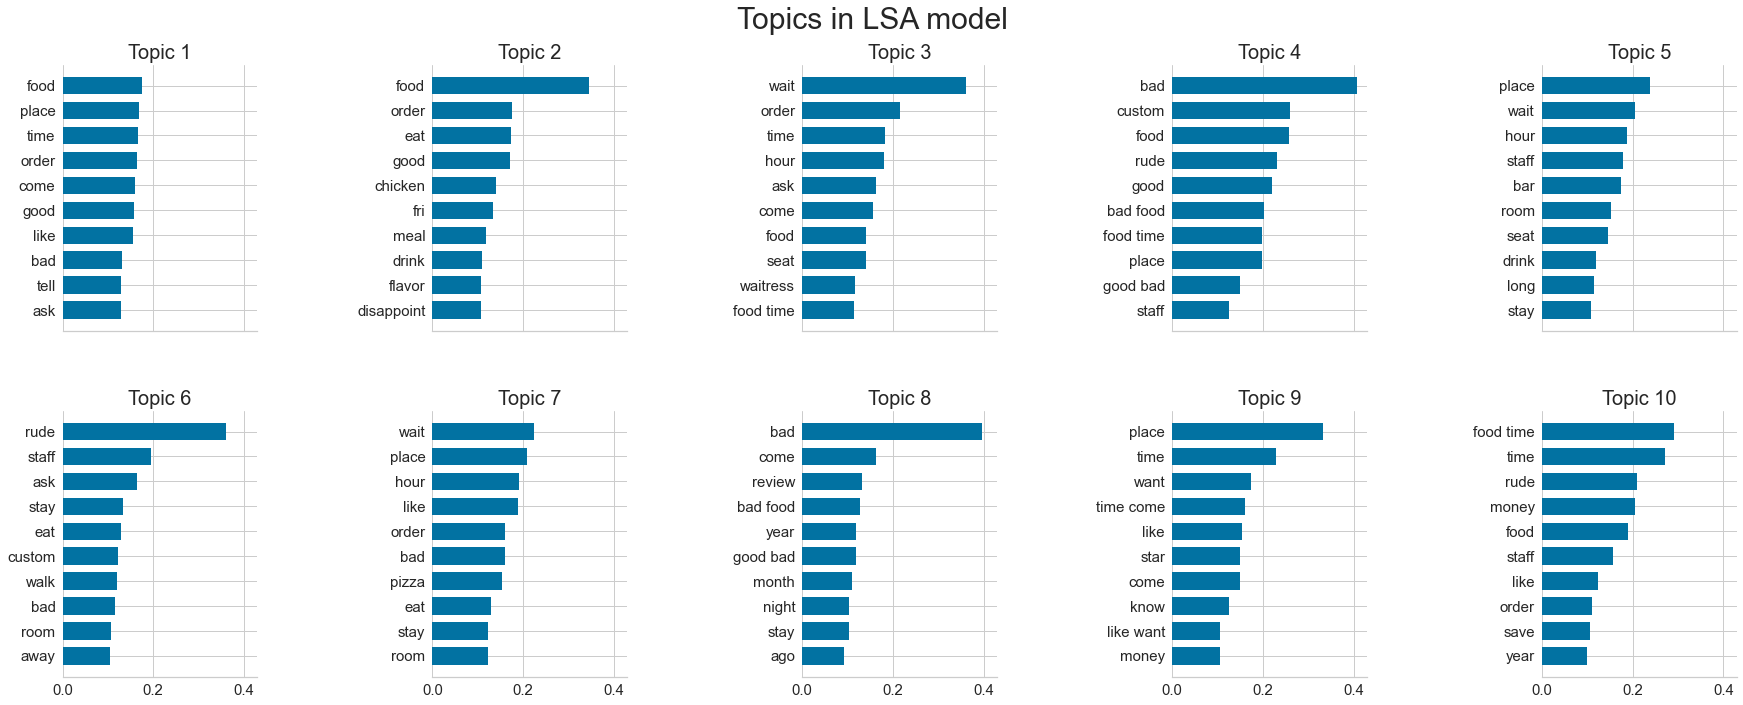

In [204]:
plot_top_words(
    lsa, X_v[index]['feature_names'], no_top_words, n_topics, "Topics in LSA model" # (Frobenius norm)
)

### LDA - sklearn

In [228]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit the LDA model
logging.info(
    "Fitting the LDA model with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (df_nlp_review[index].shape[0], df_nlp_review[index].shape[1])
)
with timer("creation and fitting lda model"):
    # Créer le modèle LDA
    lda = LatentDirichletAllocation(
            n_components=n_topics, 
            learning_method='batch', 
            #learning_offset=50.,
            random_state=1)

    # Fitter sur les données
    lda.fit(df_nlp_review[index])

creation and fitting lda model - done in 2s


In [236]:
display_topics(lda, list(df_nlp_review[index].columns), no_top_words)

Topic 0:
food order good eat place like come menu disappoint meal
Topic 1:
place like pay stay clean room buy car look bad
Topic 2:
sandwich food sandwich food ok eat line order steak bad chicken
Topic 3:
suck major ring cashier place pizza kid bowl chicken pay time
Topic 4:
slow brown burn food custom care save wait pizza cold
Topic 5:
beer order drink bar food nice good cocktail food beer work
Topic 6:
par ice sub rate tea select food music cream fan
Topic 7:
say time tell ask wait custom come hour work want
Topic 8:
food time food bad food bad good food time good place wish worth
Topic 9:
excel close bar sad light case disappoint glass like stress


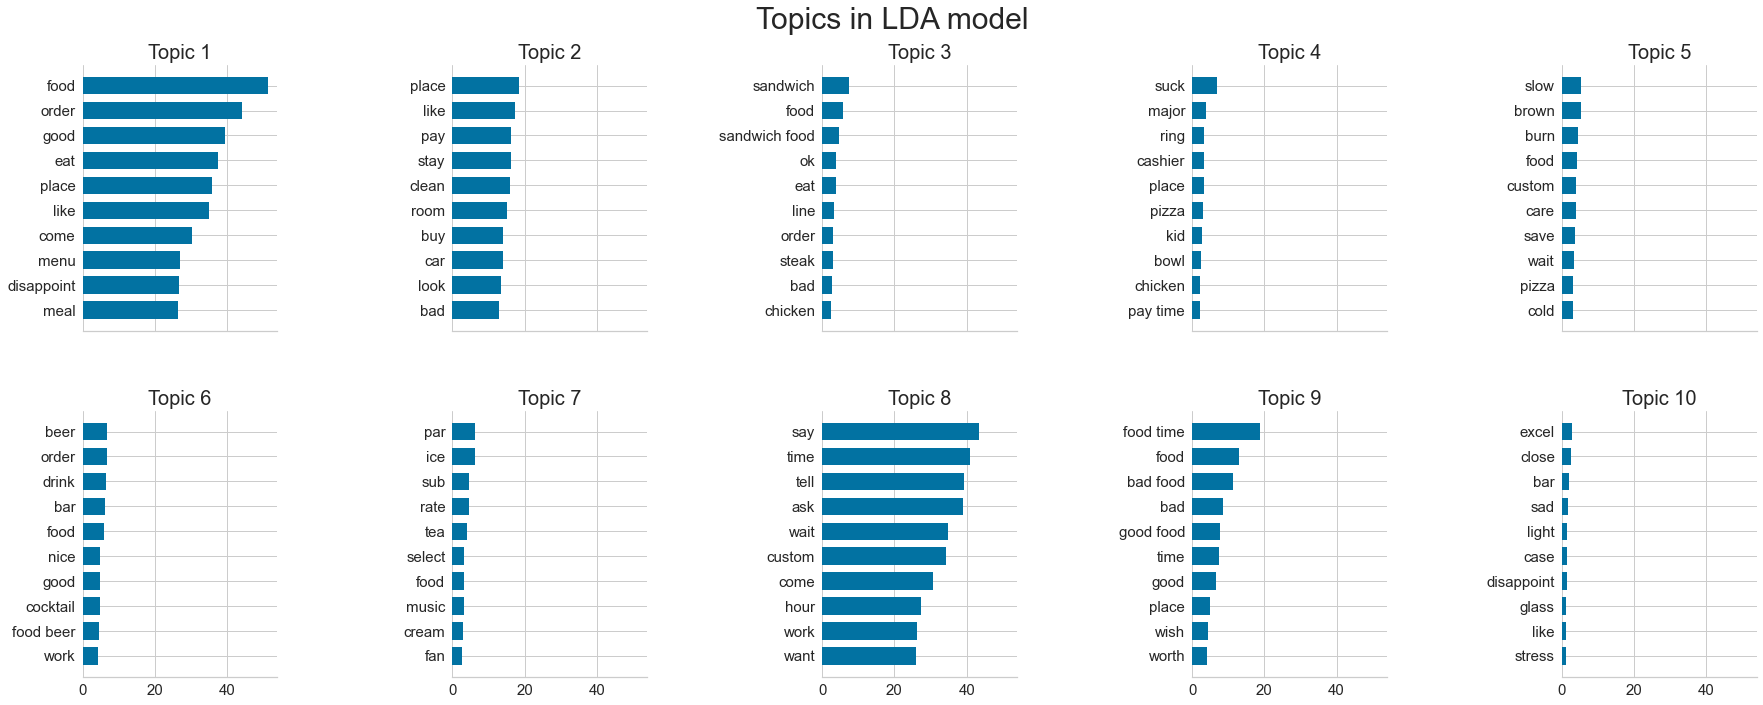

In [230]:
plot_top_words(
    lda, X_v[index]['feature_names'], no_top_words, n_topics, "Topics in LDA model" # (Frobenius norm)
)

### LDA - gensim

In [210]:
logging.getLogger().setLevel(logging.CRITICAL)

In [211]:
# in order to show jupyter lab buttons  - problem of pyLDAvis package: https://github.com/bmabey/pyLDAvis/issues/162
from IPython.display import HTML 
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>' 
display(HTML(css_str))

In [212]:
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary

In [213]:
#docs = X.parallel_apply(lambda x: preprocess_text2(x) ) #X.map(preprocess_text2)

ddf = dd.from_pandas(X, npartitions=30) # find your own number of partitions
ddf_update = ddf.apply(lambda x: preprocess_text2(x), meta=ddf)

In [214]:
docs = ddf_update.compute()

In [215]:
dictionary = Dictionary(docs)

In [216]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [217]:
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

In [218]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
n_topics=5
lda_model = LdaMulticore(
                        corpus=corpus_tfidf,
                        id2word=dictionary,
                        num_topics=n_topics,
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                )

pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternativ

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.172376 -0.008999       1        1  89.003029
4      0.035071  0.045246       2        1   2.888634
3      0.054732 -0.063281       3        1   2.847772
2      0.027227  0.041632       4        1   2.804966
0      0.055346 -0.014599       5        1   2.455600, topic_info=        Term        Freq       Total Category  logprob  loglift
1       food  314.000000  314.000000  Default  30.0000  30.0000
64      good  271.000000  271.000000  Default  29.0000  29.0000
95     order  298.000000  298.000000  Default  28.0000  28.0000
2      place  296.000000  296.000000  Default  27.0000  27.0000
98     price  177.000000  177.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
496   honest    2.719132   11.829242   Topic5  -6.4634   2.2365
589    music    3.278671   48.603216   Topic5  -6.2763   1.0105
1752   south    2.551694   18.353706   Topic5  -6.5269   1.7337
1       food    2.741888  314.718791   Topic5  -6.4551  -1.0362
2      place    2.483478  296.339758   Topic5  -6.5540  -1.0750

[291 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1534      1  0.598354      air
1534      2  0.074794      air
1534      3  0.074794      air
1534      5  0.224383      air
311       1  0.201802      ala
...     ...       ...      ...
1456      2  0.148885     wrap
1456      4  0.446655     wrap
1456      5  0.148885     wrap
2292      1  0.221605  wrapper
2292      2  0.443210  wrapper

[714 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

### NMF

In [51]:
from sklearn.decomposition import NMF

n_topics=10
# Fit the NMF model
logging.info(
    "Fitting the NMF model with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (df_nlp_review[index].shape[0], df_nlp_review[index].shape[1])
)

# Run NMF
with timer("creation and fitting nmf model"):
    nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=1, init='nndsvd')
    
    
    nmf.fit(df_nlp_review[index])

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


creation and fitting nmf model - done in 0s


In [52]:
display_topics(nmf, X_v[index]['feature_names'], no_top_words)

Topic 0:
tell say time ask know work want come day like
Topic 1:
food order good eat disappoint drink chicken like fri meal
Topic 2:
wait hour time wait long seat time min wait order long food look wait
Topic 3:
place place food good place good star way place suck avoid food place long
Topic 4:
custom order poor treat know custom food end frequent french free forward
Topic 5:
store buy pick shop sale sell select spend free forward
Topic 6:
pizza cold burn crust order pick bread say slice good way
Topic 7:
bad bad come young friend fresh frequent french free forward forget
Topic 8:
stay room hotel desk night bed clean away door room time room
Topic 9:
rude staff treat food end fresh frequent french free forward forget


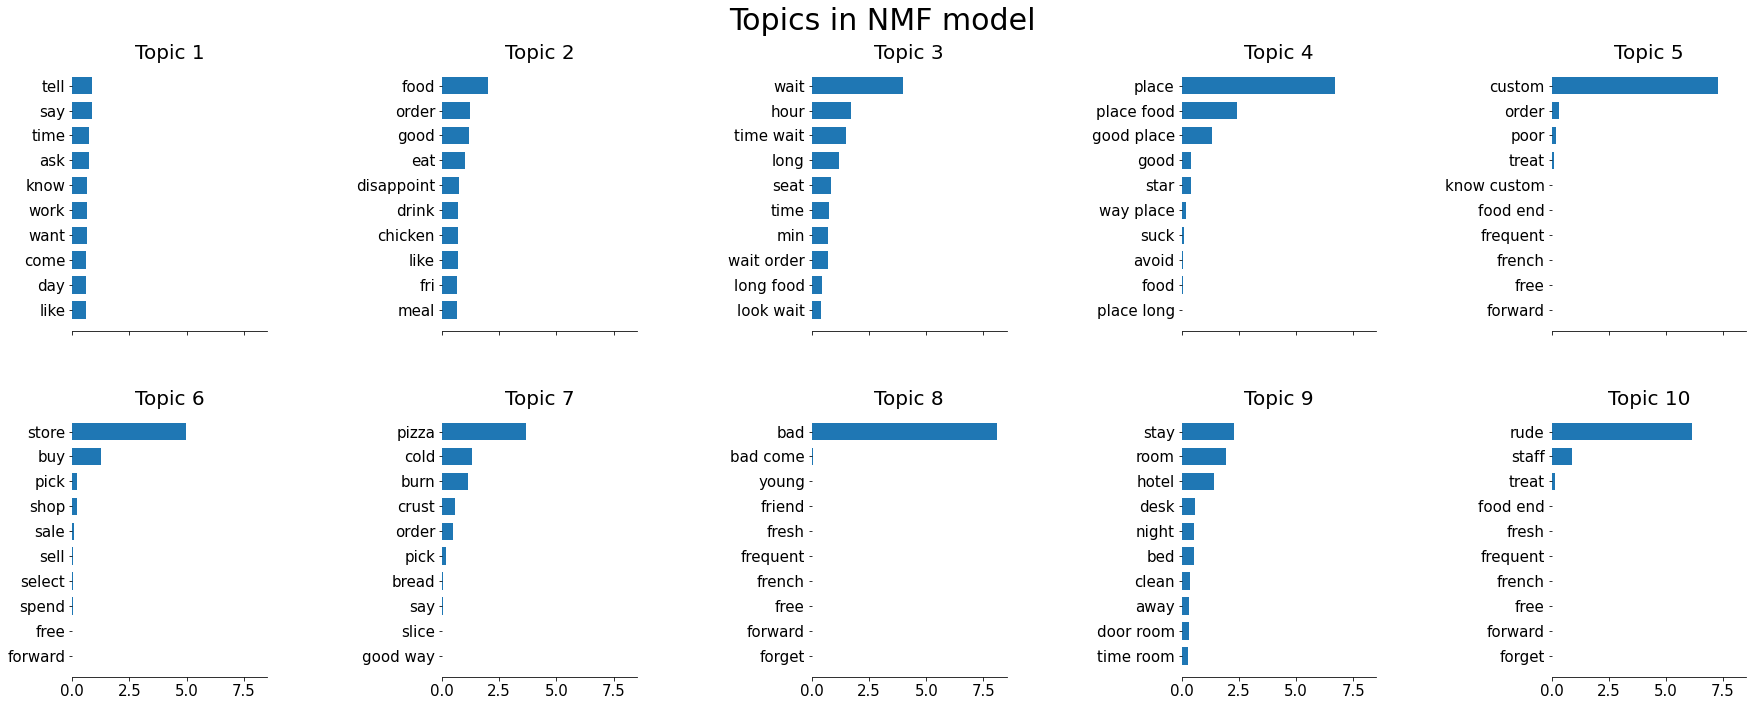

In [53]:
plot_top_words(
    nmf, X_v[index]['feature_names'], no_top_words, n_topics, "Topics in NMF model" # (Frobenius norm)
)

## Word Embedding

In [28]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(docs)
word2vec.wv.most_similar(["chicken"], topn=10)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 4187 word types from a corpus of 71005 raw words and 2347 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1621 unique words (38.72% of original 4187, drops 2566)', 'datetime': '2022-07-29T15:50:32.486581', 'gensim': '4.2.0', 'python': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 66589 word corpus (93.78% of original 71005, drops 4416)', 'datetime': '2022-07-29T15:50:32.487022', 'gensim': '4.2.0', 'python': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]', 'platform': 'mac

[('feel', 0.9991552233695984),
 ('month', 0.9986551403999329),
 ('bill', 0.9984357953071594),
 ('end', 0.9983950853347778),
 ('night', 0.9981069564819336),
 ('work', 0.9976475238800049),
 ('appoint', 0.9976390600204468),
 ('wrong', 0.9971959590911865),
 ('nice', 0.9968405961990356),
 ('long', 0.9968373775482178)]

In [30]:
from sklearn.manifold import TSNE

In [ ]:
X_w2v = pd.DataFrame([word2vec.wv[x] for x in word2vec.wv.key_to_index.keys()])
X_tsne = TSNE(random_state=1, n_jobs=-1).fit_transform(X_w2v)
X_tsne = pd.DataFrame(X_tsne, columns=['T1', 'T2'])

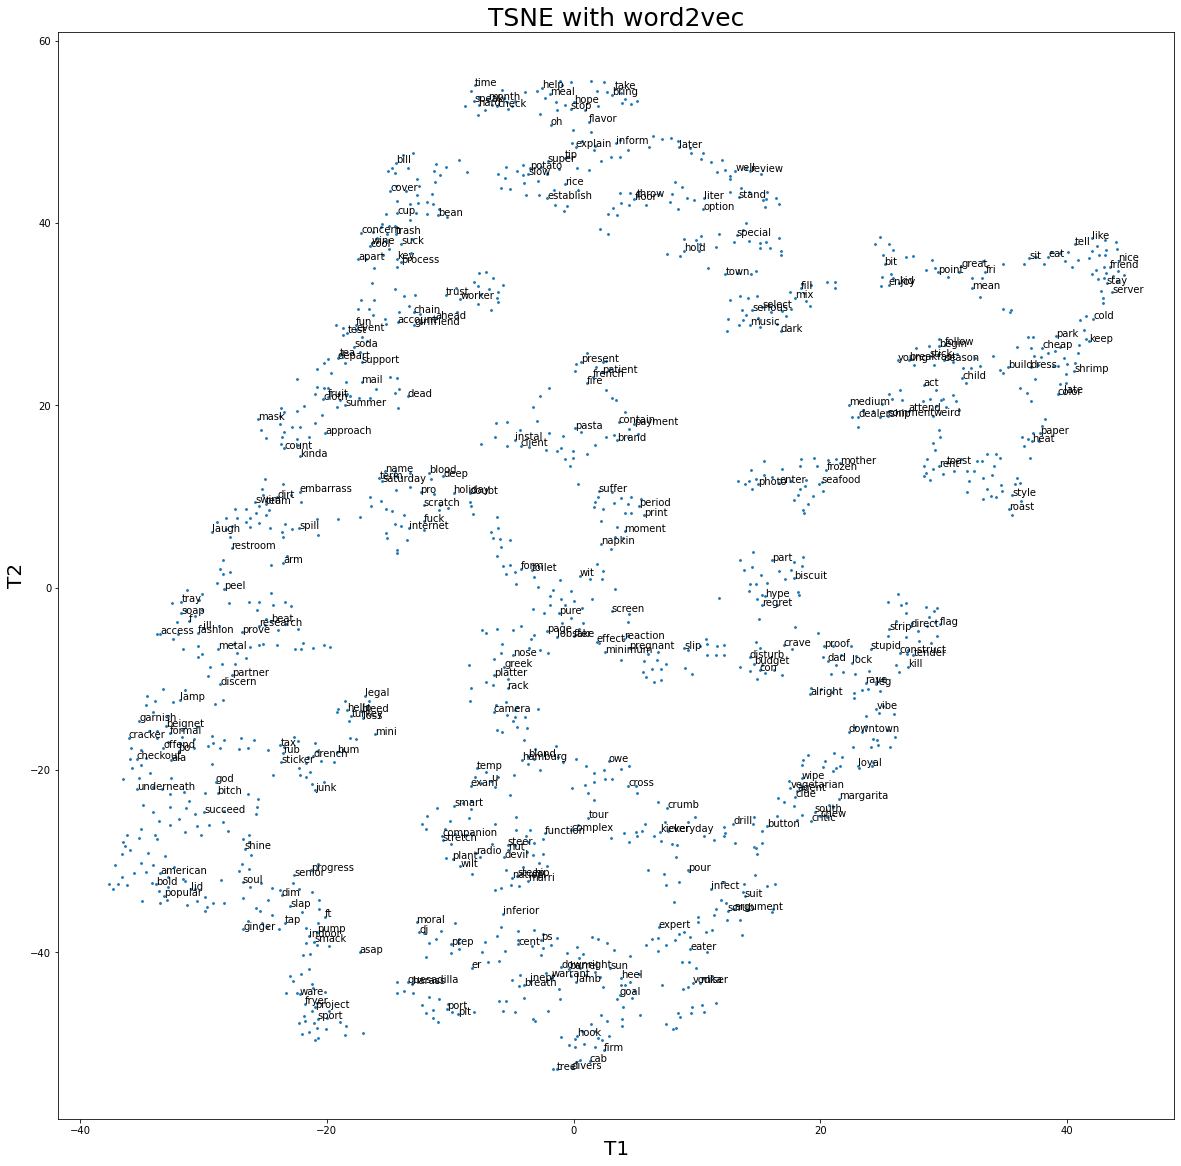

In [294]:
plt.figure(figsize=(20, 20))
sns.scatterplot(
    data = X_tsne,
    x="T1", y="T2",
    s=10
);
# Annotate label points 
for i, word in enumerate(word2vec.wv.key_to_index.keys()):
    if (i % 5)==0:
        plt.annotate(word, (X_tsne.T1[i], X_tsne.T2[i]) )
    
plt.title('TSNE with word2vec',fontsize=25);
plt.xlabel('T1',fontsize=20);
plt.ylabel('T2',fontsize=20);

# Photos dataset

In [2]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [3]:
photos_df = pd.DataFrame()
with pd.read_json("data/yelp_photos/photos.json",
    chunksize=500 * 1000,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_df = photos_df.append(chunk)
        logger.info(f"Loaded {len(photos_df)} photos")
logger.info(f">>> OK : {len(photos_df)} photos loaded from JSON file.")

# Reduce memory usage
photos_df = reduce_dataframe_memory_usage(photos_df)

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_4812/1474923334.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  photos_df = photos_df.append(chunk)
INFO:__main__:Loaded 200100 photos
INFO:__main__:>>> OK : 200100 photos loaded from JSON file.


Memory usage of dataframe is 6.11 MB
Memory usage after optimization is 4.77 MB
Decreased by 22 %%


In [4]:
photos_df.shape

(200100, 4)

In [5]:
photos_df.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [6]:
photos_df.describe()

photo_id             business_id caption   label
count                   200100                  200100  200100  200100
unique                  200098                   36680   76413       5
top     _CYoxbCIKuAwpq4crHCPWg  FEXhWNCMkv22qG04E83Qjg            food
freq                         2                     528  103366  108152

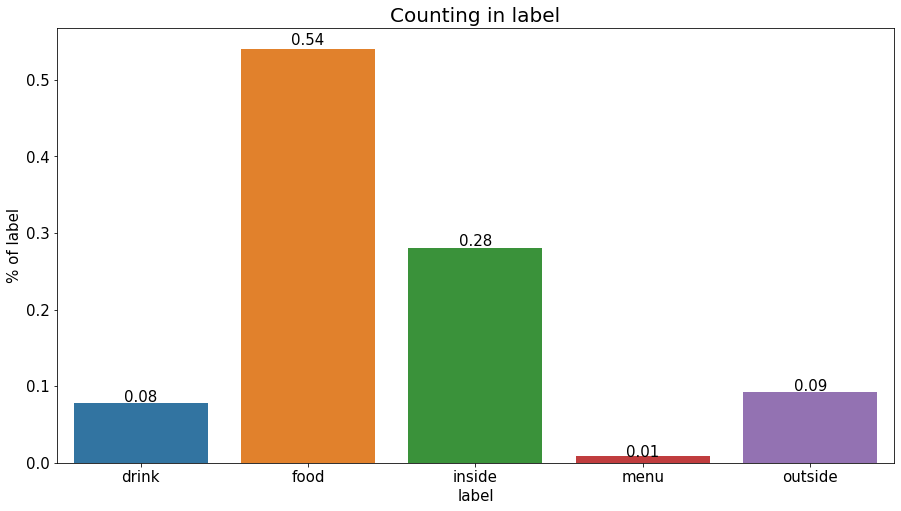

In [7]:
plot_count_col(photos_df, col='label', label_col='label', show_val = True, on_x=True)

In [8]:
drink = photos_df[photos_df.label=='drink'].iloc[:200]
food = photos_df[photos_df.label=='food'].iloc[:200]
inside = photos_df[photos_df.label=='inside'].iloc[:200]
menu = photos_df[photos_df.label=='menu'].iloc[:200]
outside = photos_df[photos_df.label=='outside'].iloc[:200]
df_photos = pd.concat([drink, food, inside, menu, outside], sort=False).reset_index(drop=True)
del drink, food, inside, menu, outside

Let us know see some examples of images from each category.

In [9]:
import cv2 as cv
#from skimage.feature import hog
#from sklearn.feature_extraction.image import extract_patches_2d

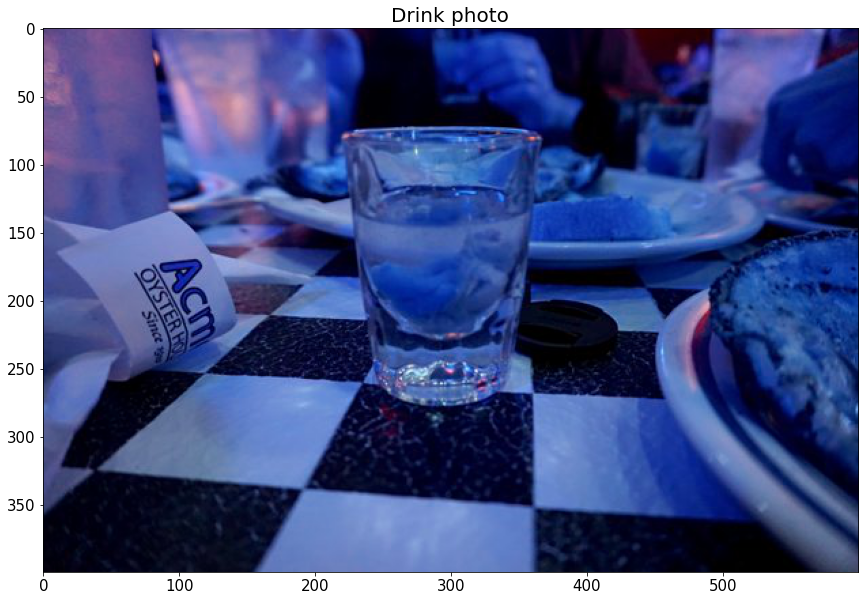

In [13]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='drink'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.title('Drink photo')
plt.imshow(img)
plt.show()

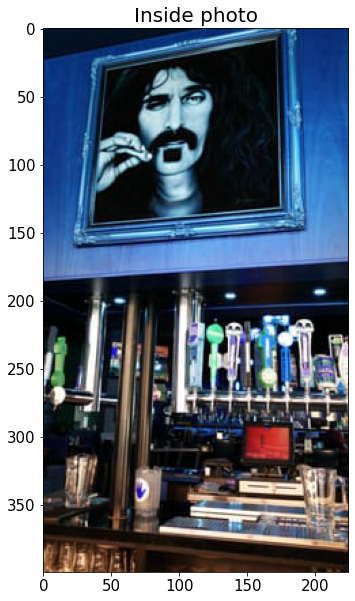

In [14]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='inside'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.title('Inside photo')
plt.imshow(img)
plt.show()

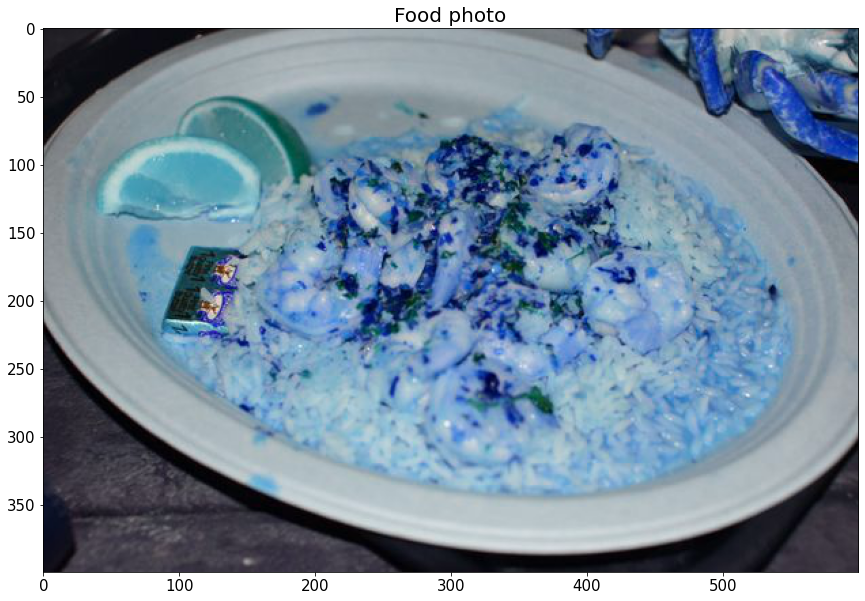

In [15]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='food'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.title('Food photo')
plt.imshow(img)
plt.show()

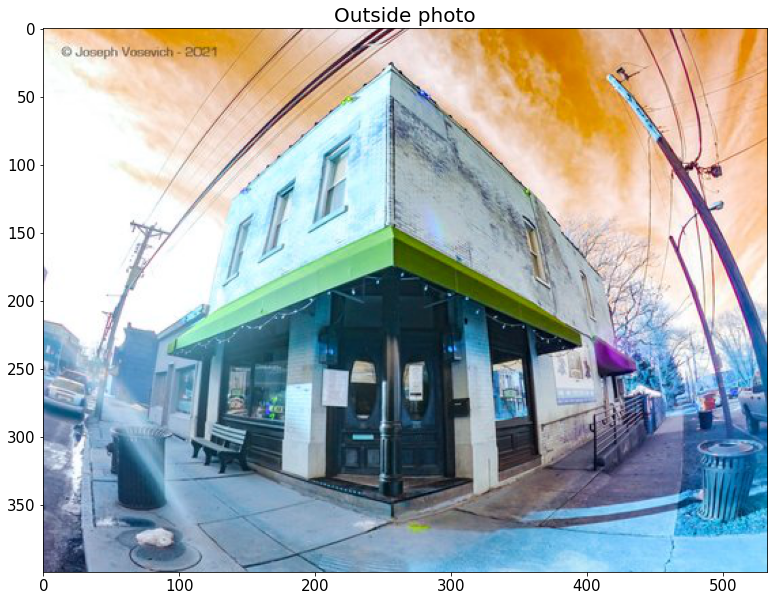

In [16]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='outside'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.title('Outside photo')
plt.imshow(img)
plt.show()

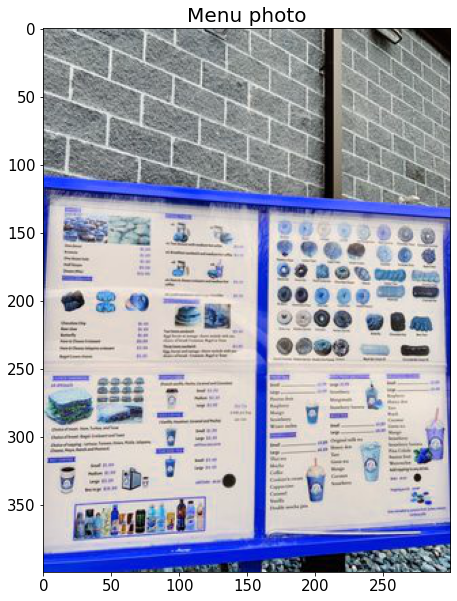

In [17]:
img_path = 'data/yelp_photos/photos/{0}.jpg'.format(df_photos[df_photos.label=='menu'].iloc[0].photo_id)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
#Show the image with matplotlib
plt.title('Menu photo')
plt.imshow(img)
plt.show()

In [18]:
img.shape

(400, 300, 3)

In this part of project we are predicting the label of the photos. But before this we need to proceed the extraction of the features in our images datasets. 
We will use the ORB (Oriented FAST and Rotated BRIEF) features.

## Visual features extraction SHIFT/ORB
 - compute the 200 first ORB keypoints of the image. 
 - compute the 200 first SIFT keypoints of the image. 

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
df_photos_features = pd.DataFrame()

#df_orb_features = pd.DataFrame(columns = [i for i in range(128*100)])
#df_sift_features = pd.DataFrame(columns = [i for i in range(128*100)])

dim = (128, 128)

for photo in df_photos.itertuples():
    # Load image
    img_path = 'data/yelp_photos/photos/{0}.jpg'.format(photo.photo_id)

    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
    
    #img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    #print(img.shape) (128, 128, 3)
    
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    
    #kernel_sharpening = np.array([[-1,-1,-1], 
    #                          [-1,9,-1], 
    #                          [-1,-1,-1]])
    #img_gray = cv.filter2D(img_gray, -1, kernel_sharpening)

    # ORB Features
    orb = cv.ORB_create(nfeatures=200)
    orb_keypoints = orb.detect(img_gray, None)
    orb_keypoints, orb_descriptors = orb.compute(img_gray, orb_keypoints)
    #print(orb_descriptors.shape)

    # create SIFT object
    sift = cv.xfeatures2d.SIFT_create(nfeatures=200)
    sift_keypoints = sift.detect(img_gray, None)
    sift_keypoints, sift_descriptors = sift.compute(img_gray, sift_keypoints)
    #print(sift_descriptors.shape)

    dict_to_add = {"file_name": photo.photo_id, "label": photo.label, "orb_keypoints": orb_keypoints, "orb_descriptors": orb_descriptors, "sift_keypoints": sift_keypoints, "sift_descriptors": sift_descriptors}
    df_photos_features = df_photos_features.append(dict_to_add,ignore_index=True)

    df_photos_features.dropna(inplace=True)
    

In [54]:
df_photos_features.head()

file_name  label  \
0  vkr8T0scuJmGVvN2HJelEA  drink   
1  VYP7IZ8SjyRLM1II5WcKew  drink   
2  pRnGI7xv7ZBJ8p_w0xy9fg  drink   
3  Iehiw_bcHnXw-pg0w2M06w  drink   
4  1q1aIcuJMdeTt8QEyXFIeQ  drink   

                                       orb_keypoints  \
0  [<KeyPoint 0x2fc640390>, <KeyPoint 0x2fc6403c0...   
1  [<KeyPoint 0x2fc5f95a0>, <KeyPoint 0x2fc5f9540...   
2  [<KeyPoint 0x2fc653690>, <KeyPoint 0x2fc6536c0...   
3  [<KeyPoint 0x2fc657300>, <KeyPoint 0x2fc657330...   
4  [<KeyPoint 0x2fc4401e0>, <KeyPoint 0x2fc4b1f00...   

                                     orb_descriptors  \
0  [[215, 28, 239, 7, 18, 62, 234, 48, 237, 226, ...   
1  [[184, 215, 28, 250, 57, 137, 83, 188, 151, 20...   
2  [[53, 141, 43, 238, 213, 246, 238, 104, 84, 64...   
3  [[6, 236, 51, 208, 87, 153, 175, 235, 254, 151...   
4  [[120, 184, 188, 242, 169, 253, 93, 191, 171, ...   

                                      sift_keypoints  \
0  [<KeyPoint 0x2fc64d0c0>, <KeyPoint 0x2fc64d0f0...   
1  [<KeyPoint 0x2fc651060>, <KeyPoint 0x2fc651090...   
2  [<KeyPoint 0x2fc654c90>, <KeyPoint 0x2fc654cc0...   
3  [<KeyPoint 0x2fc659900>, <KeyPoint 0x2fc659930...   
4  [<KeyPoint 0x2fc65e420>, <KeyPoint 0x2fc65e450...   

                                    sift_descriptors  
0  [[20.0, 17.0, 6.0, 2.0, 25.0, 61.0, 8.0, 9.0, ...  
1  [[32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 88...  
2  [[14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 22.0, 13...  
3  [[9.0, 1.0, 7.0, 13.0, 4.0, 1.0, 48.0, 80.0, 1...  
4  [[32.0, 22.0, 3.0, 5.0, 0.0, 0.0, 0.0, 0.0, 16...

### SIFT features
Now we use the SIFT features to group different keypoints detected from the SIFT algorithm. We start by creation of our dataset of SIFT features.

In [55]:
sift_features = np.array([
    descriptor for photo_sift_feature in df_photos_features["sift_descriptors"] for descriptor in photo_sift_feature
])
sift_features.shape

(198782, 128)

In [56]:
sift_features

array([[ 20.,  17.,   6., ...,  12.,   0.,   0.],
       [126.,  22.,   0., ...,   2.,   0.,   1.],
       [ 39.,   0.,   0., ...,  11.,   0.,   0.],
       ...,
       [ 90.,   5.,   6., ...,  21.,  60.,  38.],
       [ 34.,   0.,   0., ...,   0.,   0.,   0.],
       [ 42.,   2.,   0., ..., 115.,   0.,   0.]], dtype=float32)

Scalling the sift features

In [58]:
sift_scaler = RobustScaler().fit(sift_features)
sift_features_std = sift_scaler.transform(sift_features)

We use the Elbow method to define the number of clusters

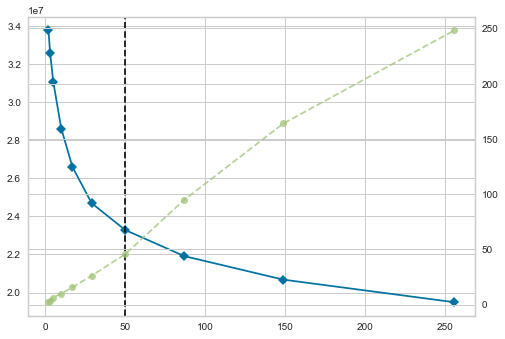

In [59]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=10, init='k-means++')
visualizer = KElbowVisualizer(model, k=np.logspace(start=1, stop=8, base=2, num=10, dtype=int))

vis = visualizer.fit(sift_features_std);    # Fit the data to the visualizer

In [60]:
visualizer.poof();    # Draw/show/poof the data

Bag of visual-words representing the photo: Now we train our clustering model and count the number of occurrences of each SIFT cluster for each photo.

In [61]:
from sklearn.cluster import KMeans


K = 50
sift_kmeans = KMeans(n_clusters=K, random_state=10).fit(sift_features_std)

df_photos_features["sift_clusters"] = [
    sift_kmeans.predict(sift_scaler.transform(desc))
    for desc in df_photos_features["sift_descriptors"]
]

for cluster in range(K):
    df_photos_features[f"sift_cluster_{cluster}"] = 0

    for i, photo in df_photos_features.iterrows():
        df_photos_features.loc[i, f"sift_cluster_{cluster}"] = list(
            df_photos_features.loc[i, "sift_clusters"]
        ).count(cluster)

df_photos_features[
    ["sift_clusters"] + [f"sift_cluster_{i}" for i in range(K)]
].head(5)



sift_clusters  sift_cluster_0  \
0  [29, 19, 29, 34, 14, 31, 26, 44, 15, 10, 12, 4...               3   
1  [19, 27, 24, 46, 10, 10, 19, 19, 11, 21, 29, 1...               2   
2  [29, 46, 33, 15, 15, 47, 5, 13, 11, 30, 49, 12...               4   
3  [41, 34, 48, 40, 14, 37, 8, 44, 8, 45, 45, 14,...               3   
4  [13, 10, 1, 18, 32, 10, 14, 38, 31, 4, 38, 13,...               0   

   sift_cluster_1  sift_cluster_2  sift_cluster_3  sift_cluster_4  \
0               8               0               4               8   
1               3               0               3               1   
2               2               3               6               8   
3               2               3               0               3   
4               9               1              12               5   

   sift_cluster_5  sift_cluster_6  sift_cluster_7  sift_cluster_8  ...  \
0               3               8               5               0  ...   
1               9               1               7               1  ...   
2               2               6               4               0  ...   
3               5               1               5               5  ...   
4               0               3               6               0  ...   

   sift_cluster_40  sift_cluster_41  sift_cluster_42  sift_cluster_43  \
0                7                0                4                0   
1                0                3                1                0   
2                2                0                4                2   
3                8               14                6                3   
4                5                0                1                1   

   sift_cluster_44  sift_cluster_45  sift_cluster_46  sift_cluster_47  \
0                5                4                4                2   
1                1                0                4                2   
2                5                8               10                2   
3                4                8                1                2   
4                5                4                1                4   

   sift_cluster_48  sift_cluster_49  
0                1                2  
1                2                3  
2                0                1  
3               10                3  
4                0                7  

[5 rows x 51 columns]

### ORB features

Now we use the ORB features to group different keypoints detected from the ORB algorithm. We start by creation of our dataset of ORB features.

In [62]:
orb_features = np.array([
    descriptor for photo_orb_feature in df_photos_features["orb_descriptors"] for descriptor in photo_orb_feature
])
orb_features.shape

(198515, 32)

In [63]:
orb_features

array([[215,  28, 239, ..., 227,  41,  52],
       [249,  92,  19, ...,  17,  42,  28],
       [103,  72, 236, ..., 184,  92,  84],
       ...,
       [124, 200, 150, ..., 125, 124, 142],
       [ 29, 105, 240, ..., 183,  79, 162],
       [ 58,  20, 182, ...,  76,  61, 251]], dtype=uint8)

Scalling the orb features

In [64]:
orb_scaler = RobustScaler().fit(orb_features)
orb_features_std = orb_scaler.transform(orb_features)

We use the Elbow method to define the number of clusters

In [65]:
# Instantiate the clustering model and visualizer 
from yellowbrick.cluster import KElbowVisualizer

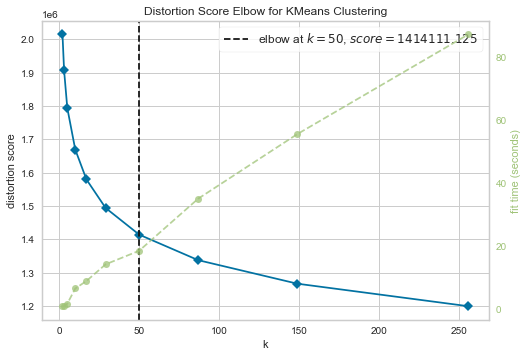

In [66]:
from sklearn.cluster import KMeans
# Instantiate the clustering model and visualizer
model = KMeans(random_state=10, init='k-means++')
visualizer = KElbowVisualizer(model, k=np.logspace(start=1, stop=8, base=2, num=10, dtype=int))

vis = visualizer.fit(orb_features_std);    # Fit the data to the visualizer

visualizer.poof();    # Draw/show/poof the data

Bag of visual-words representing the photo:
Now we train our clustering model and count the number of occurrences of each ORB cluster for each photo. 

In [67]:
from sklearn.cluster import KMeans


K = 50
orb_kmeans = KMeans(n_clusters=K, random_state=10).fit(orb_features_std)

df_photos_features["orb_clusters"] = [
    orb_kmeans.predict(orb_scaler.transform(desc))
    for desc in df_photos_features["orb_descriptors"]
]

for cluster in range(K):
    df_photos_features[f"orb_cluster_{cluster}"] = 0

    for i, photo in df_photos_features.iterrows():
        df_photos_features.loc[i, f"orb_cluster_{cluster}"] = list(
            df_photos_features.loc[i, "orb_clusters"]
        ).count(cluster)

df_photos_features[
    ["orb_clusters"] + [f"orb_cluster_{i}" for i in range(K)]
].head(5)

orb_clusters  orb_cluster_0  \
0  [19, 34, 5, 10, 7, 29, 28, 22, 27, 19, 29, 1, ...              3   
1  [41, 21, 41, 28, 13, 49, 27, 23, 19, 34, 0, 23...              8   
2  [35, 10, 45, 6, 29, 44, 18, 38, 32, 0, 24, 47,...              7   
3  [12, 32, 4, 38, 30, 6, 2, 10, 42, 26, 7, 27, 4...              2   
4  [18, 47, 31, 49, 31, 31, 9, 22, 24, 36, 44, 37...              5   

   orb_cluster_1  orb_cluster_2  orb_cluster_3  orb_cluster_4  orb_cluster_5  \
0              6              3              4              5              9   
1              2              2              3              2              4   
2              2              4              9              4              2   
3              9              2              5              4              1   
4              4              2              3              4              3   

   orb_cluster_6  orb_cluster_7  orb_cluster_8  ...  orb_cluster_40  \
0              2              4              8  ...               1   
1              2              6              1  ...               0   
2              3              7              6  ...               5   
3              4              5              3  ...               4   
4              4              3              0  ...               1   

   orb_cluster_41  orb_cluster_42  orb_cluster_43  orb_cluster_44  \
0               3               3               0               1   
1               7               1               2               1   
2               2               0               1               5   
3               2              14               5               1   
4              12               6               6               7   

   orb_cluster_45  orb_cluster_46  orb_cluster_47  orb_cluster_48  \
0               2               0               3               3   
1               1               3               1               2   
2               2               0               3               1   
3               0               3               7               6   
4               1               3               4               0   

   orb_cluster_49  
0               0  
1               6  
2               6  
3               3  
4              10  

[5 rows x 51 columns]

Bag of visual-words representing will be used next in the clustering task.

### Creation datasets

In [68]:
df_photos_features.head()

file_name  label  \
0  vkr8T0scuJmGVvN2HJelEA  drink   
1  VYP7IZ8SjyRLM1II5WcKew  drink   
2  pRnGI7xv7ZBJ8p_w0xy9fg  drink   
3  Iehiw_bcHnXw-pg0w2M06w  drink   
4  1q1aIcuJMdeTt8QEyXFIeQ  drink   

                                       orb_keypoints  \
0  [<KeyPoint 0x2fc640390>, <KeyPoint 0x2fc6403c0...   
1  [<KeyPoint 0x2fc5f95a0>, <KeyPoint 0x2fc5f9540...   
2  [<KeyPoint 0x2fc653690>, <KeyPoint 0x2fc6536c0...   
3  [<KeyPoint 0x2fc657300>, <KeyPoint 0x2fc657330...   
4  [<KeyPoint 0x2fc4401e0>, <KeyPoint 0x2fc4b1f00...   

                                     orb_descriptors  \
0  [[215, 28, 239, 7, 18, 62, 234, 48, 237, 226, ...   
1  [[184, 215, 28, 250, 57, 137, 83, 188, 151, 20...   
2  [[53, 141, 43, 238, 213, 246, 238, 104, 84, 64...   
3  [[6, 236, 51, 208, 87, 153, 175, 235, 254, 151...   
4  [[120, 184, 188, 242, 169, 253, 93, 191, 171, ...   

                                      sift_keypoints  \
0  [<KeyPoint 0x2fc64d0c0>, <KeyPoint 0x2fc64d0f0...   
1  [<KeyPoint 0x2fc651060>, <KeyPoint 0x2fc651090...   
2  [<KeyPoint 0x2fc654c90>, <KeyPoint 0x2fc654cc0...   
3  [<KeyPoint 0x2fc659900>, <KeyPoint 0x2fc659930...   
4  [<KeyPoint 0x2fc65e420>, <KeyPoint 0x2fc65e450...   

                                    sift_descriptors  \
0  [[20.0, 17.0, 6.0, 2.0, 25.0, 61.0, 8.0, 9.0, ...   
1  [[32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 88...   
2  [[14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 22.0, 13...   
3  [[9.0, 1.0, 7.0, 13.0, 4.0, 1.0, 48.0, 80.0, 1...   
4  [[32.0, 22.0, 3.0, 5.0, 0.0, 0.0, 0.0, 0.0, 16...   

                                       sift_clusters  sift_cluster_0  \
0  [29, 19, 29, 34, 14, 31, 26, 44, 15, 10, 12, 4...               3   
1  [19, 27, 24, 46, 10, 10, 19, 19, 11, 21, 29, 1...               2   
2  [29, 46, 33, 15, 15, 47, 5, 13, 11, 30, 49, 12...               4   
3  [41, 34, 48, 40, 14, 37, 8, 44, 8, 45, 45, 14,...               3   
4  [13, 10, 1, 18, 32, 10, 14, 38, 31, 4, 38, 13,...               0   

   sift_cluster_1  sift_cluster_2  ...  orb_cluster_40  orb_cluster_41  \
0               8               0  ...               1               3   
1               3               0  ...               0               7   
2               2               3  ...               5               2   
3               2               3  ...               4               2   
4               9               1  ...               1              12   

   orb_cluster_42  orb_cluster_43  orb_cluster_44  orb_cluster_45  \
0               3               0               1               2   
1               1               2               1               1   
2               0               1               5               2   
3              14               5               1               0   
4               6               6               7               1   

   orb_cluster_46  orb_cluster_47  orb_cluster_48  orb_cluster_49  
0               0               3               3               0  
1               3               1               2               6  
2               0               3               1               6  
3               3               7               6               3  
4               3               4               0              10  

[5 rows x 108 columns]

In [69]:
from sklearn.model_selection import train_test_split

K= 50
y = df_photos_features.label

#SHIFT

X_shift = df_photos_features[[f"sift_cluster_{cluster}" for cluster in range(K)]]

shift_scaler = StandardScaler().fit(X_shift) # RobustScaler().fit(X_shift)
X_shift_std = shift_scaler.transform(X_shift)
X_shift_std = pd.DataFrame(X_shift_std, columns = ['SC_{0}'.format(i) for i in range(50)])

X_train_shift, X_test_shift, y_train_shift, y_test_shift = train_test_split(
    X_shift_std,
    y,
    stratify=y,
    random_state=1,
)

X_train_shift = X_train_shift.reset_index(drop=True)
X_test_shift = X_test_shift.reset_index(drop=True)
y_train_shift = y_train_shift.reset_index(drop=True)
y_test_shift = y_test_shift.reset_index(drop=True)


# ORB
X_orb = df_photos_features[[f"orb_cluster_{cluster}" for cluster in range(K)]]


orb_scaler = StandardScaler().fit(X_orb) # RobustScaler().fit(X_orb)
X_orb_std = orb_scaler.transform(X_orb)
X_orb_std = pd.DataFrame(X_orb_std, columns = ['OC_{0}'.format(i) for i in range(50)])

X_train_orb, X_test_orb, y_train_orb, y_test_orb = train_test_split(
    X_orb_std,
    y,
    stratify=y,
    random_state=1,
)

X_train_orb = X_train_orb.reset_index(drop=True)
X_test_orb = X_test_orb.reset_index(drop=True)
y_train_orb = y_train_orb.reset_index(drop=True)
y_test_orb = y_test_orb.reset_index(drop=True)

In [70]:
X_shift_std

SC_0      SC_1      SC_2      SC_3      SC_4      SC_5      SC_6  \
0    0.008375  1.782151 -1.247126  0.029108  2.059131 -0.271108  1.690361   
1   -0.355744 -0.178411 -1.247126 -0.283877 -0.856305  1.163328 -0.989106   
2    0.372494 -0.570524 -0.234026  0.655076  2.059131 -0.510181  0.924799   
3    0.008375 -0.570524 -0.234026 -1.222829 -0.023323  0.207037 -0.989106   
4   -1.083982  2.174263 -0.909426  2.532980  0.809658 -0.988327 -0.223544   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.008375 -0.570524 -0.234026 -0.909845  1.226149 -0.988327 -0.606325   
996 -0.719863 -0.570524  0.441374 -0.596861 -0.439814  0.446110 -0.223544   
997 -0.355744 -0.962636  1.454474  0.342092  0.393167 -0.988327  0.542018   
998 -0.719863  0.213701  0.103674  0.968060  1.642640 -0.271108  0.159237   
999 -0.355744  0.997926 -0.571726  0.029108  0.393167  0.685182  1.307580   

         SC_7      SC_8      SC_9  ...     SC_40     SC_41     SC_42  \
0    0.156119 -0.723247  0.523925  ...  1.087914 -0.632709  0.050189   
1    0.842357 -0.547488  0.127012  ... -0.985997  0.106437 -0.795693   
2   -0.187000 -0.723247  1.714664  ... -0.393451 -0.632709  0.050189   
3    0.156119  0.155546  0.127012  ...  1.384187  2.816637  0.614111   
4    0.499238 -0.723247 -1.063727  ...  0.495368 -0.632709 -0.795693   
..        ...       ...       ...  ...       ...       ...       ...   
995  1.528594 -0.020212  0.523925  ...  0.791641 -0.139945  1.178032   
996  1.185475 -0.371730 -0.269901  ...  0.495368 -0.139945 -0.513733   
997  1.185475  0.155546  0.127012  ...  0.791641 -0.632709  0.332150   
998 -0.873237 -0.723247  0.127012  ... -0.393451 -0.386327  0.896071   
999 -0.187000 -0.723247 -0.666814  ... -0.097178  0.352819 -0.513733   

        SC_43     SC_44     SC_45     SC_46     SC_47     SC_48     SC_49  
0   -0.730720  0.035107 -0.095998 -0.253532 -0.457679 -0.229133 -0.454356  
1   -0.730720 -1.218728 -0.558641 -0.253532 -0.457679 -0.052469 -0.078233  
2   -0.123810  0.035107  0.366644  1.419946 -0.457679 -0.405798 -0.830478  
3    0.179645 -0.278351  0.366644 -1.090271 -0.457679  1.360844 -0.078233  
4   -0.427265  0.035107 -0.095998 -1.090271  0.438852 -0.405798  1.426256  
..        ...       ...       ...       ...       ...       ...       ...  
995 -0.427265  0.035107 -0.327319  0.304294  2.231914  0.477523 -0.830478  
996  0.786555  0.035107  0.019662  0.025381  0.887118 -0.229133 -0.454356  
997 -0.427265 -0.905269  0.250983 -0.811358 -0.009414 -0.052469 -0.830478  
998 -0.123810  1.288942 -0.442980 -0.253532  0.887118 -0.229133 -0.830478  
999 -0.427265 -0.278351  0.135323  1.419946  1.335383 -0.052469 -0.830478  

[1000 rows x 50 columns]

In [237]:
X_orb_std

OC_0      OC_1      OC_2      OC_3      OC_4      OC_5      OC_6  \
0   -0.149545  0.570283 -0.461875 -0.040512  0.481090  1.563193 -0.623000   
1    1.411465 -0.502181 -0.746807 -0.412182 -0.500059  0.045825 -0.623000   
2    1.099263 -0.502181 -0.176943  1.817836  0.154040 -0.561123 -0.262884   
3   -0.461747  1.374631 -0.746807  0.331158  0.154040 -0.864597  0.097231   
4    0.474859  0.034051 -0.746807 -0.412182  0.154040 -0.257649  0.097231   
..        ...       ...       ...       ...       ...       ...       ...   
995 -1.086151  0.570283 -0.746807 -0.040512  1.462239 -1.168070  0.097231   
996 -0.149545  0.838399 -0.461875  0.331158  0.481090 -0.257649  0.817462   
997 -1.086151  0.302167 -0.746807  1.074497  0.481090  0.349298  1.537693   
998 -0.773949  0.302167  0.392921 -0.412182  1.462239 -0.257649 -0.623000   
999  1.099263 -0.770297  0.107989  2.189506  3.097488  0.652772  0.097231   

         OC_7      OC_8      OC_9  ...     OC_40     OC_41     OC_42  \
0    0.199086  0.501994 -0.780651  ... -1.018654 -0.534705 -0.331840   
1    1.003476 -0.550404 -0.780651  ... -1.373092  0.521503 -1.005628   
2    1.405671  0.201309 -0.780651  ...  0.399097 -0.798757 -1.342522   
3    0.601281 -0.249719  0.285084  ...  0.044659 -0.798757  3.373991   
4   -0.203108 -0.700747  0.018650  ... -1.018654  1.841763  0.678841   
..        ...       ...       ...  ...       ...       ...       ...   
995  1.405671  0.652337  0.551518  ... -0.309779 -0.270653 -0.668734   
996  0.601281  1.253707 -0.780651  ...  1.462411  1.577711  0.005053   
997  1.807865 -0.400062  0.285084  ... -1.373092 -0.798757 -0.331840   
998  0.601281  1.253707 -0.514217  ...  0.044659  1.313659 -1.342522   
999  0.601281 -0.249719 -0.247783  ... -1.018654  1.577711 -0.331840   

        OC_43     OC_44     OC_45     OC_46     OC_47     OC_48     OC_49  
0   -1.500251 -0.961166 -0.571131 -0.973278 -0.215031 -0.317742 -1.222774  
1   -0.783799 -0.961166 -0.902030 -0.191529 -0.872616 -0.555751  0.596830  
2   -1.142025  0.488557 -0.571131 -0.973278 -0.215031 -0.793760  0.596830  
3    0.290880 -0.961166 -1.232929 -0.191529  1.100141  0.396285 -0.312972  
4    0.649106  1.213418 -0.902030 -0.191529  0.113762 -1.031769  1.809900  
..        ...       ...       ...       ...       ...       ...       ...  
995  0.290880 -1.323597 -0.571131 -0.191529  0.113762  1.348321 -1.222774  
996 -0.783799 -0.236305  1.745160 -0.712695 -0.872616 -1.031769 -0.009705  
997 -0.783799 -0.598736  2.406957  0.329638  0.771348 -0.555751 -0.616239  
998  1.007332 -0.961166 -0.571131 -0.191529  0.113762 -0.079733 -1.222774  
999 -0.425573 -1.323597 -0.902030  0.850804 -0.872616 -0.317742  0.293563  

[1000 rows x 50 columns]

In [72]:
y

0        drink
1        drink
2        drink
3        drink
4        drink
        ...   
995    outside
996    outside
997    outside
998    outside
999    outside
Name: label, Length: 1000, dtype: object

In [241]:
X_shift_std.to_pickle("data/processed/X_shift_std.pkl.gz")
X_orb_std.to_pickle("data/processed/X_orb_std.pkl.gz")
df_photos_features.label.to_pickle("data/processed/labels_photos.pkl.gz")

### PCA on bag of visual words obtained within ORB and SIFT features

In [73]:
from sklearn.decomposition import PCA
pca_features_ratio_shift = {}
pca_features_ratio_orb = {}
explained_by_pca = 0.40

is_not_selected=True
pca_shift = PCA(random_state=10)
pca_shift.fit(X_shift_std)
for k in range(X_shift_std.shape[1]):
    s = np.cumsum(pca_shift.explained_variance_ratio_)[k]
    pca_features_ratio_shift[k] = s
    if ((s>=explained_by_pca) & is_not_selected):
        n_comp_shift = k
        is_not_selected = False
        
        
is_not_selected=True
pca_orb = PCA(random_state=10)
pca_orb.fit(X_orb_std)
for k in range(X_orb_std.shape[1]):
    s = np.cumsum(pca_orb.explained_variance_ratio_)[k]
    pca_features_ratio_orb[k] = s
    if ((s>=explained_by_pca) & is_not_selected):
        n_comp_orb = k
        is_not_selected = False

In [74]:
#import numpy as np
#from sklearn.decomposition import PCA
#test = np.array([[-1, -1, 1, 3, 5, 2, 0], [-2, -1, 0, 5, 2, 8, 1], [-3, -2, 1, -3, -2, 0, 2], [1, 1, 0, -1, -1, 3, 3], [2, 1, 1, 2, 3, 0, 1], [3, 2, 0, -2, 3, 1, -1]])
#pca = PCA(random_state=10)
#pca.fit(test)
#for k in range(test.shape[1]):
#    print(np.cumsum(pca.explained_variance_ratio_)[k])

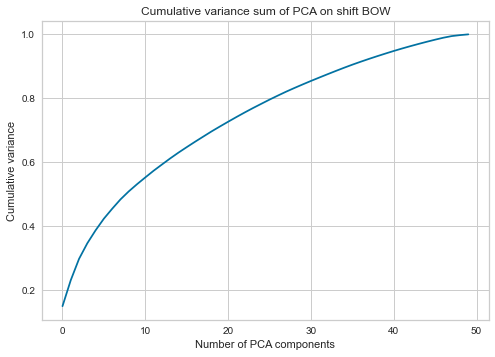

In [75]:
plt.title('Cumulative variance sum of PCA on shift BOW');
plt.xlabel('Number of PCA components');
plt.ylabel('Cumulative variance');
plt.plot(list(range(X_shift_std.shape[1])),
np.cumsum(pca_shift.explained_variance_ratio_), '-x');

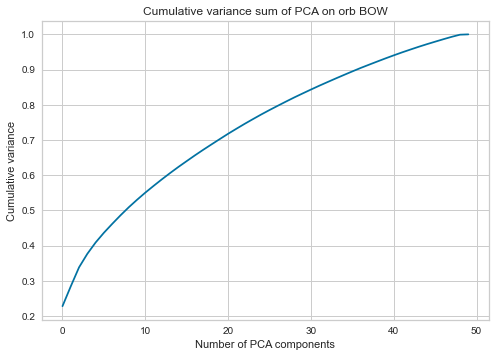

In [76]:
plt.title('Cumulative variance sum of PCA on orb BOW');
plt.xlabel('Number of PCA components');
plt.ylabel('Cumulative variance');
plt.plot(list(range(X_orb_std.shape[1])),
np.cumsum(pca_orb.explained_variance_ratio_), '-x');

In [77]:
n_comp_shift

5

In [78]:
n_comp_orb

4

In [79]:
from sklearn import decomposition
pca_shift = decomposition.PCA(n_components=n_comp_shift, random_state=10)
pca_shift.fit(X_shift_std)

X_projected_shift = pca_shift.transform(X_shift_std)
X_projected_shift = pd.DataFrame(X_projected_shift, columns = ['F{0}'.format(i) for i in range(n_comp_shift)])


pca_orb = decomposition.PCA(n_components=n_comp_orb, random_state=10)
pca_orb.fit(X_orb_std)

X_projected_orb = pca_orb.transform(X_orb_std)
X_projected_orb = pd.DataFrame(X_projected_orb, columns = ['F{0}'.format(i) for i in range(n_comp_orb)])

### Photos visualization

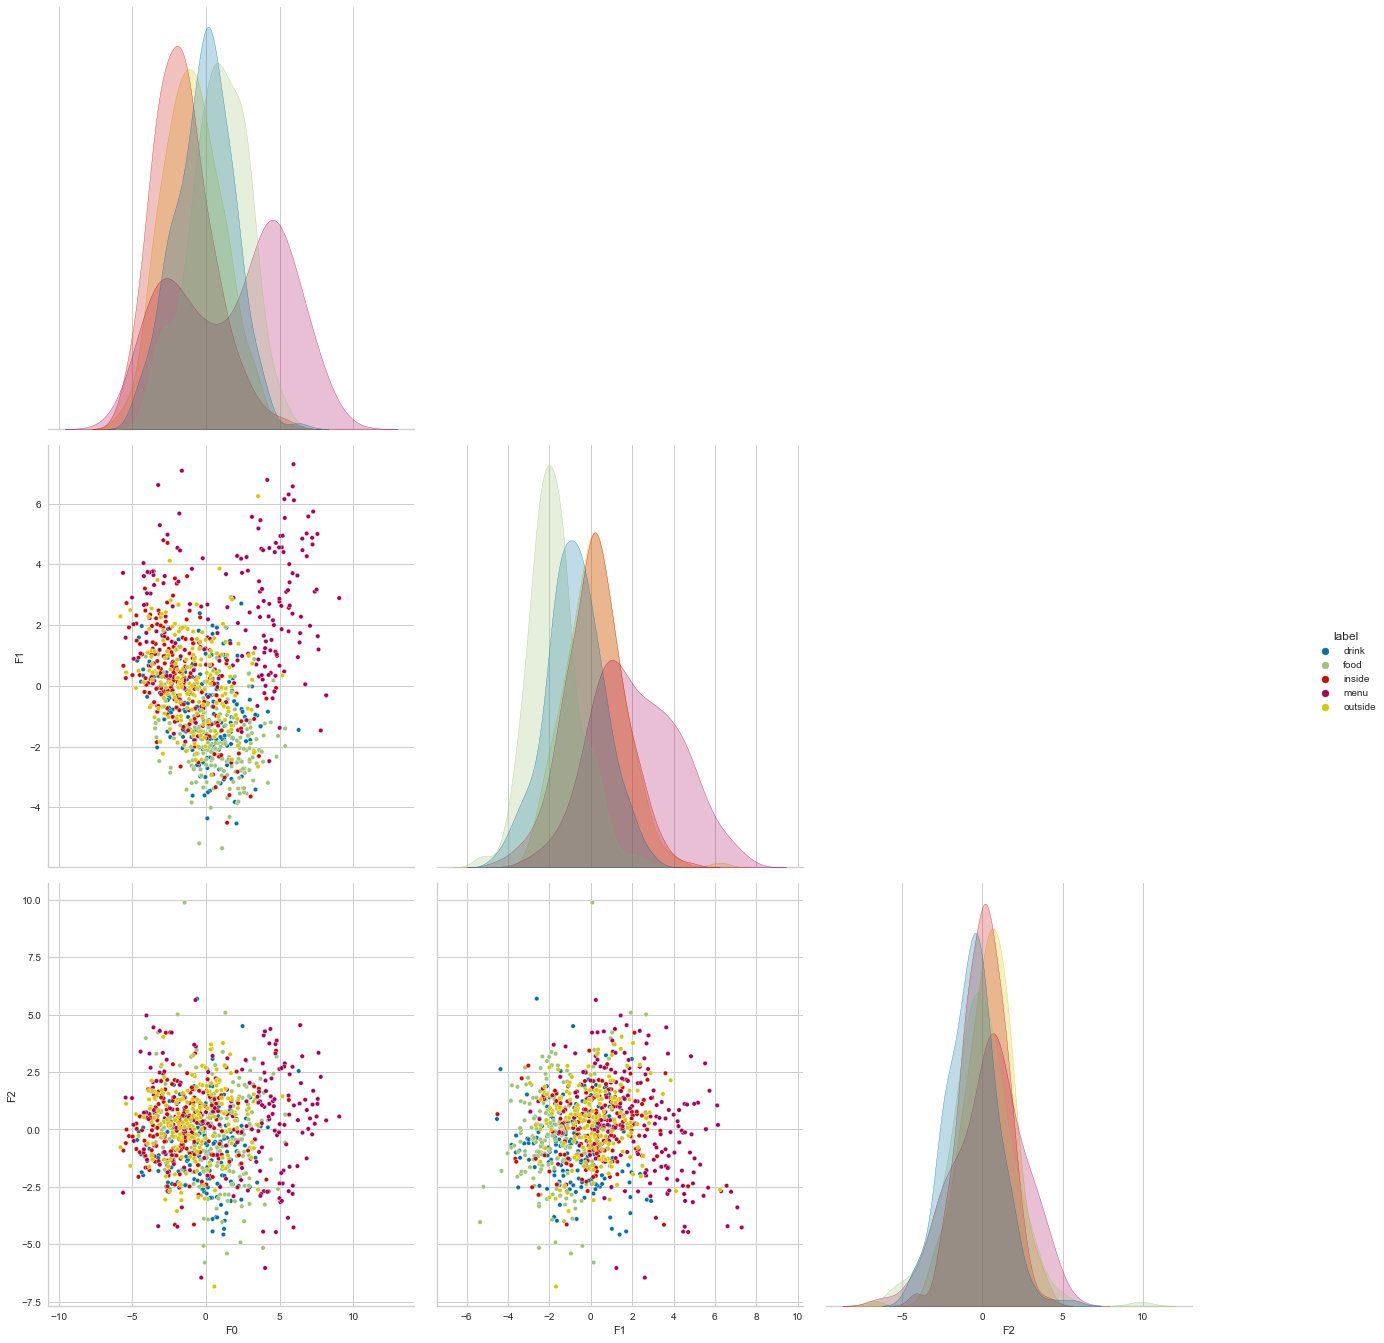

In [80]:
N = 3
to_plot = X_projected_shift.iloc[: , :N]
to_plot.loc[:,'label'] = df_photos_features.label
g=sns.pairplot(to_plot, plot_kws = {'s': 20}, corner=True, hue='label')
g.fig.set_size_inches(20,20)
del to_plot

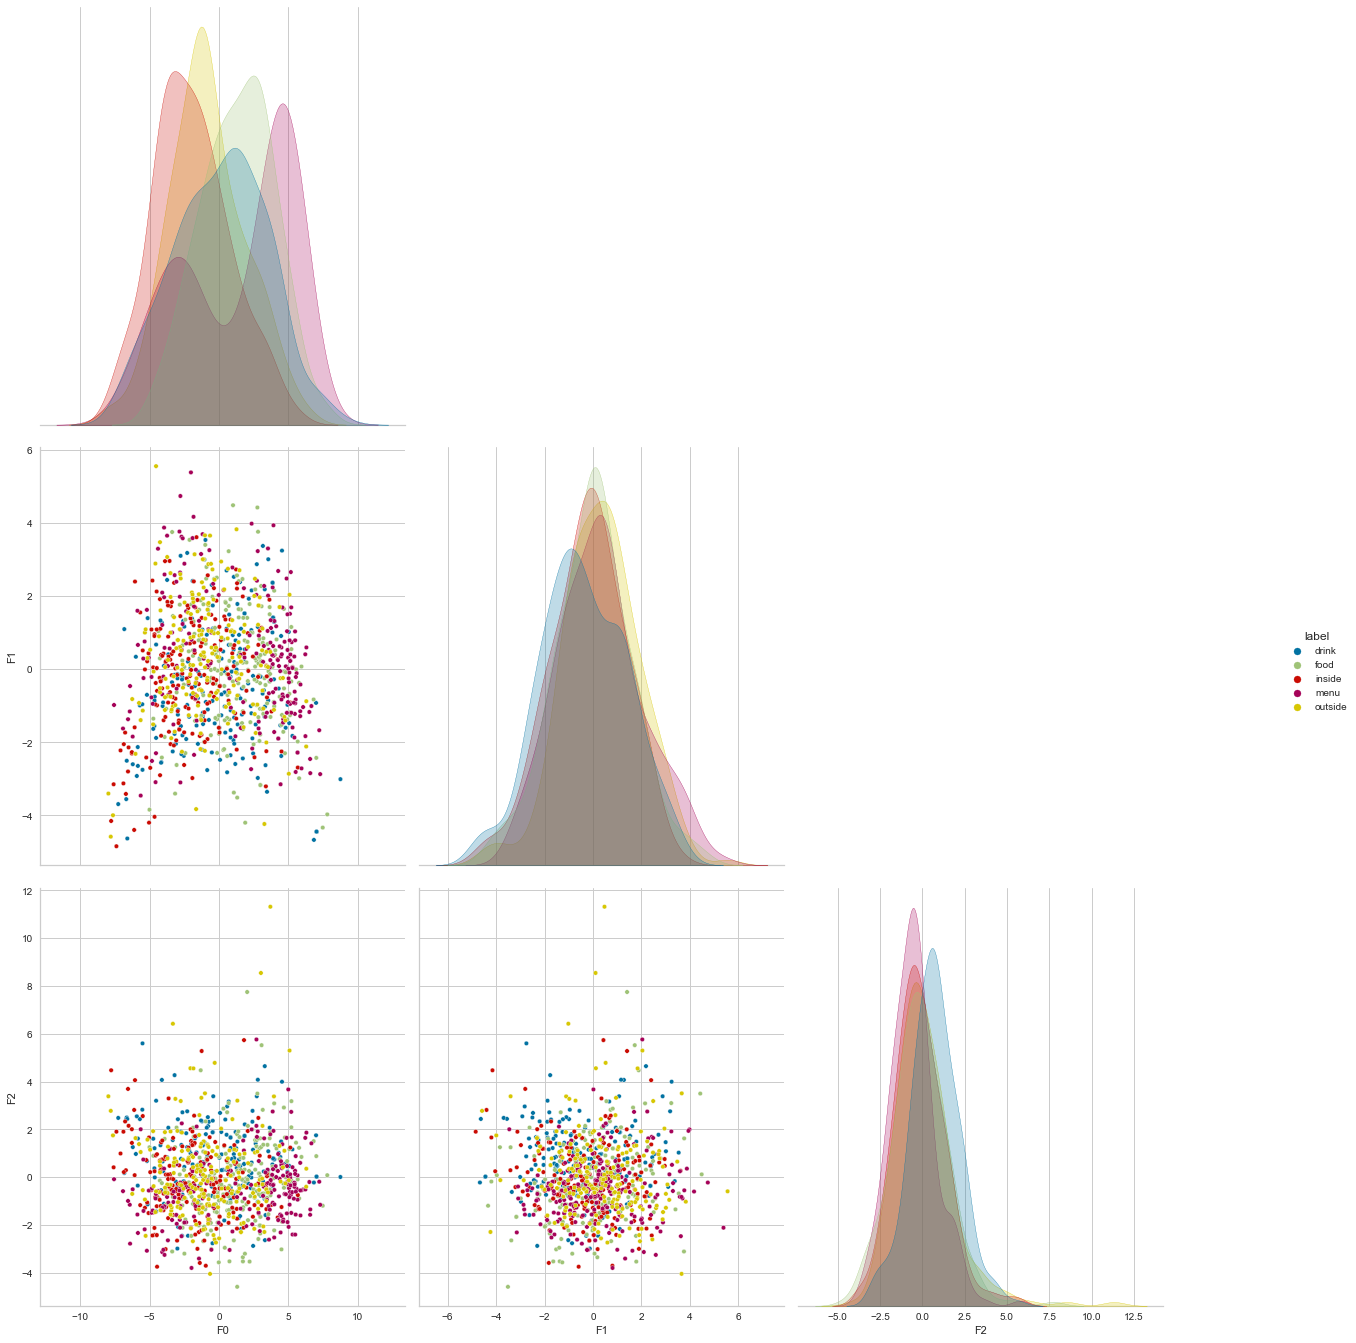

In [81]:
N = 3
to_plot = X_projected_orb.iloc[: , :N]
to_plot.loc[:,'label'] = df_photos_features.label
g=sns.pairplot(to_plot, plot_kws = {'s': 20}, corner=True, hue='label')
g.fig.set_size_inches(20,20)
del to_plot

In [82]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=1)
T_shift = tsne.fit_transform(X_projected_shift)
T_shift = pd.DataFrame(T_shift, columns=['T1', 'T2'])

tsne = TSNE(n_components=2, init='pca', random_state=1)
T_orb = tsne.fit_transform(X_projected_orb)
T_orb = pd.DataFrame(T_orb, columns=['T1', 'T2'])

In [83]:
T_shift.loc[:,'label'] = df_photos_features.label
T_orb.loc[:,'label'] = df_photos_features.label

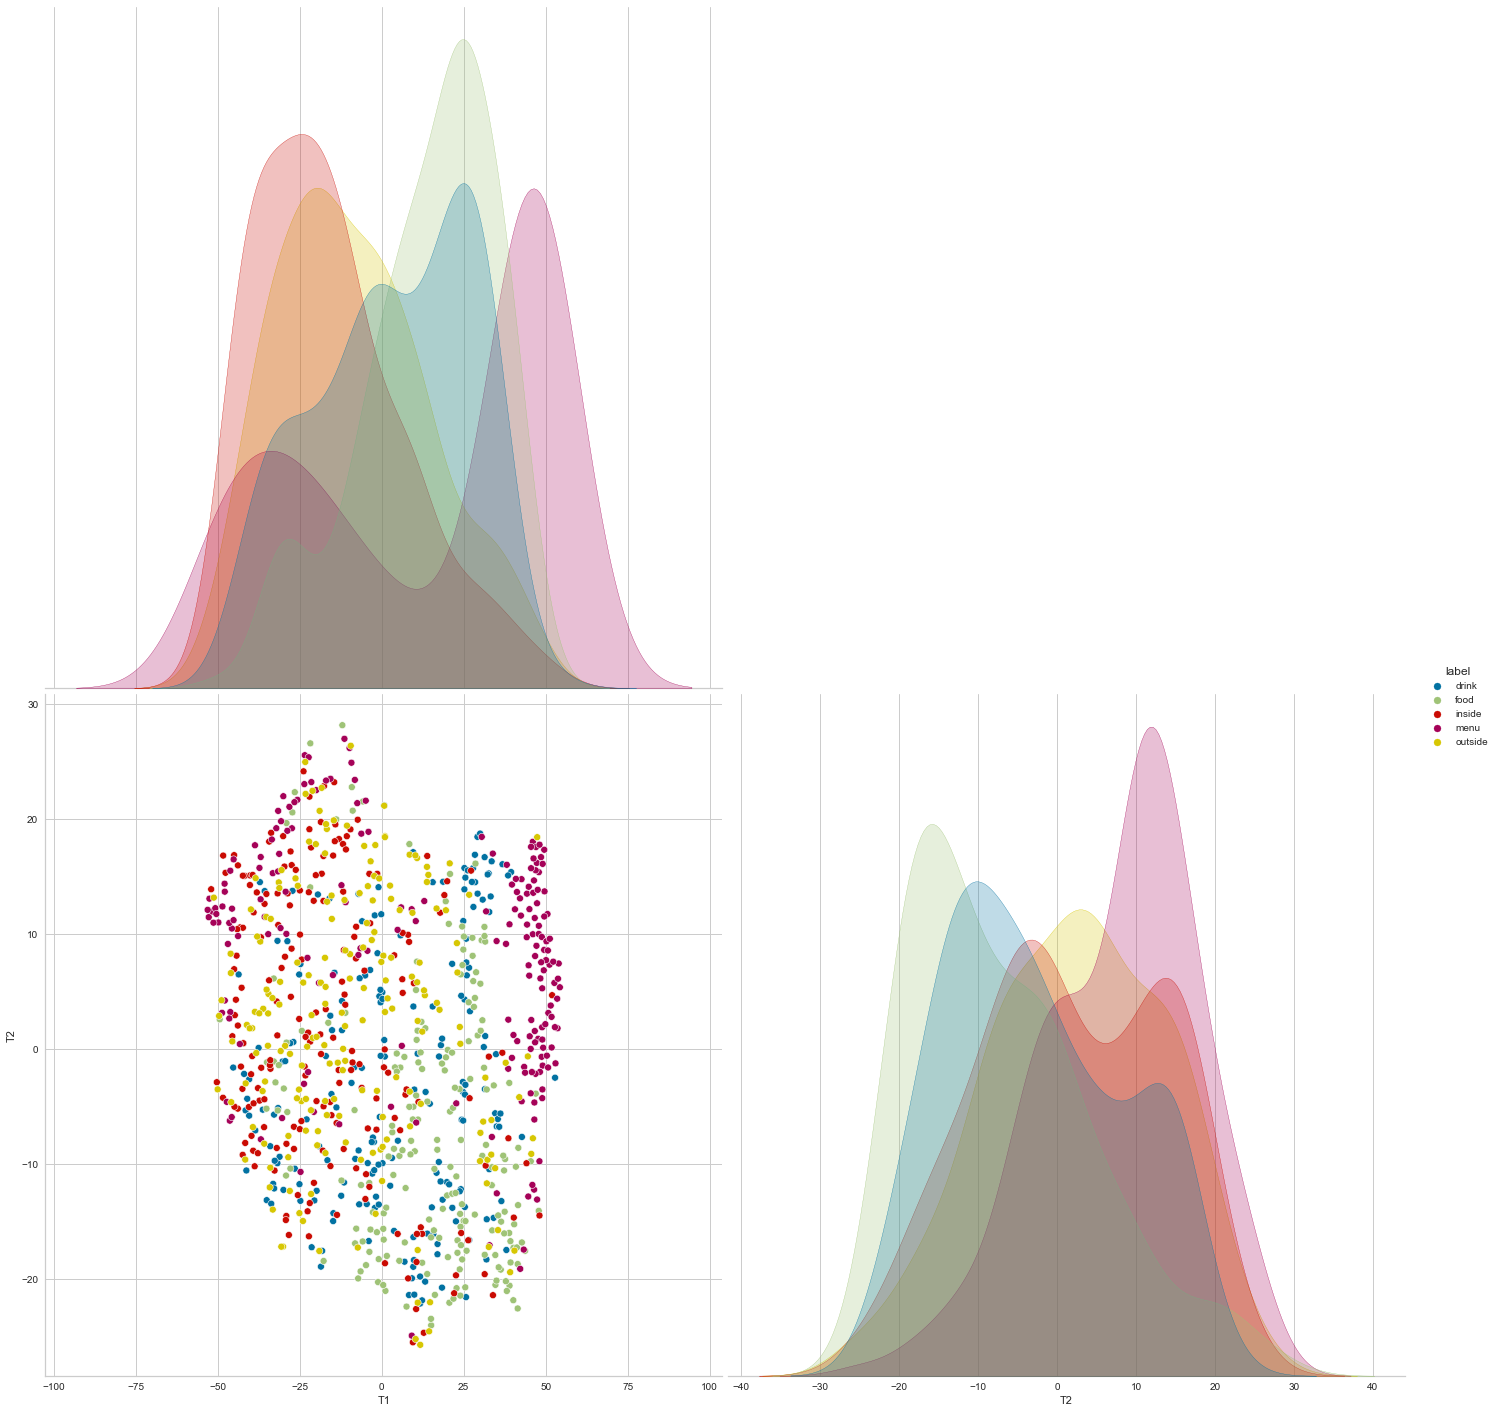

In [84]:
sns.pairplot(T_shift, size=10, corner=True, hue='label')

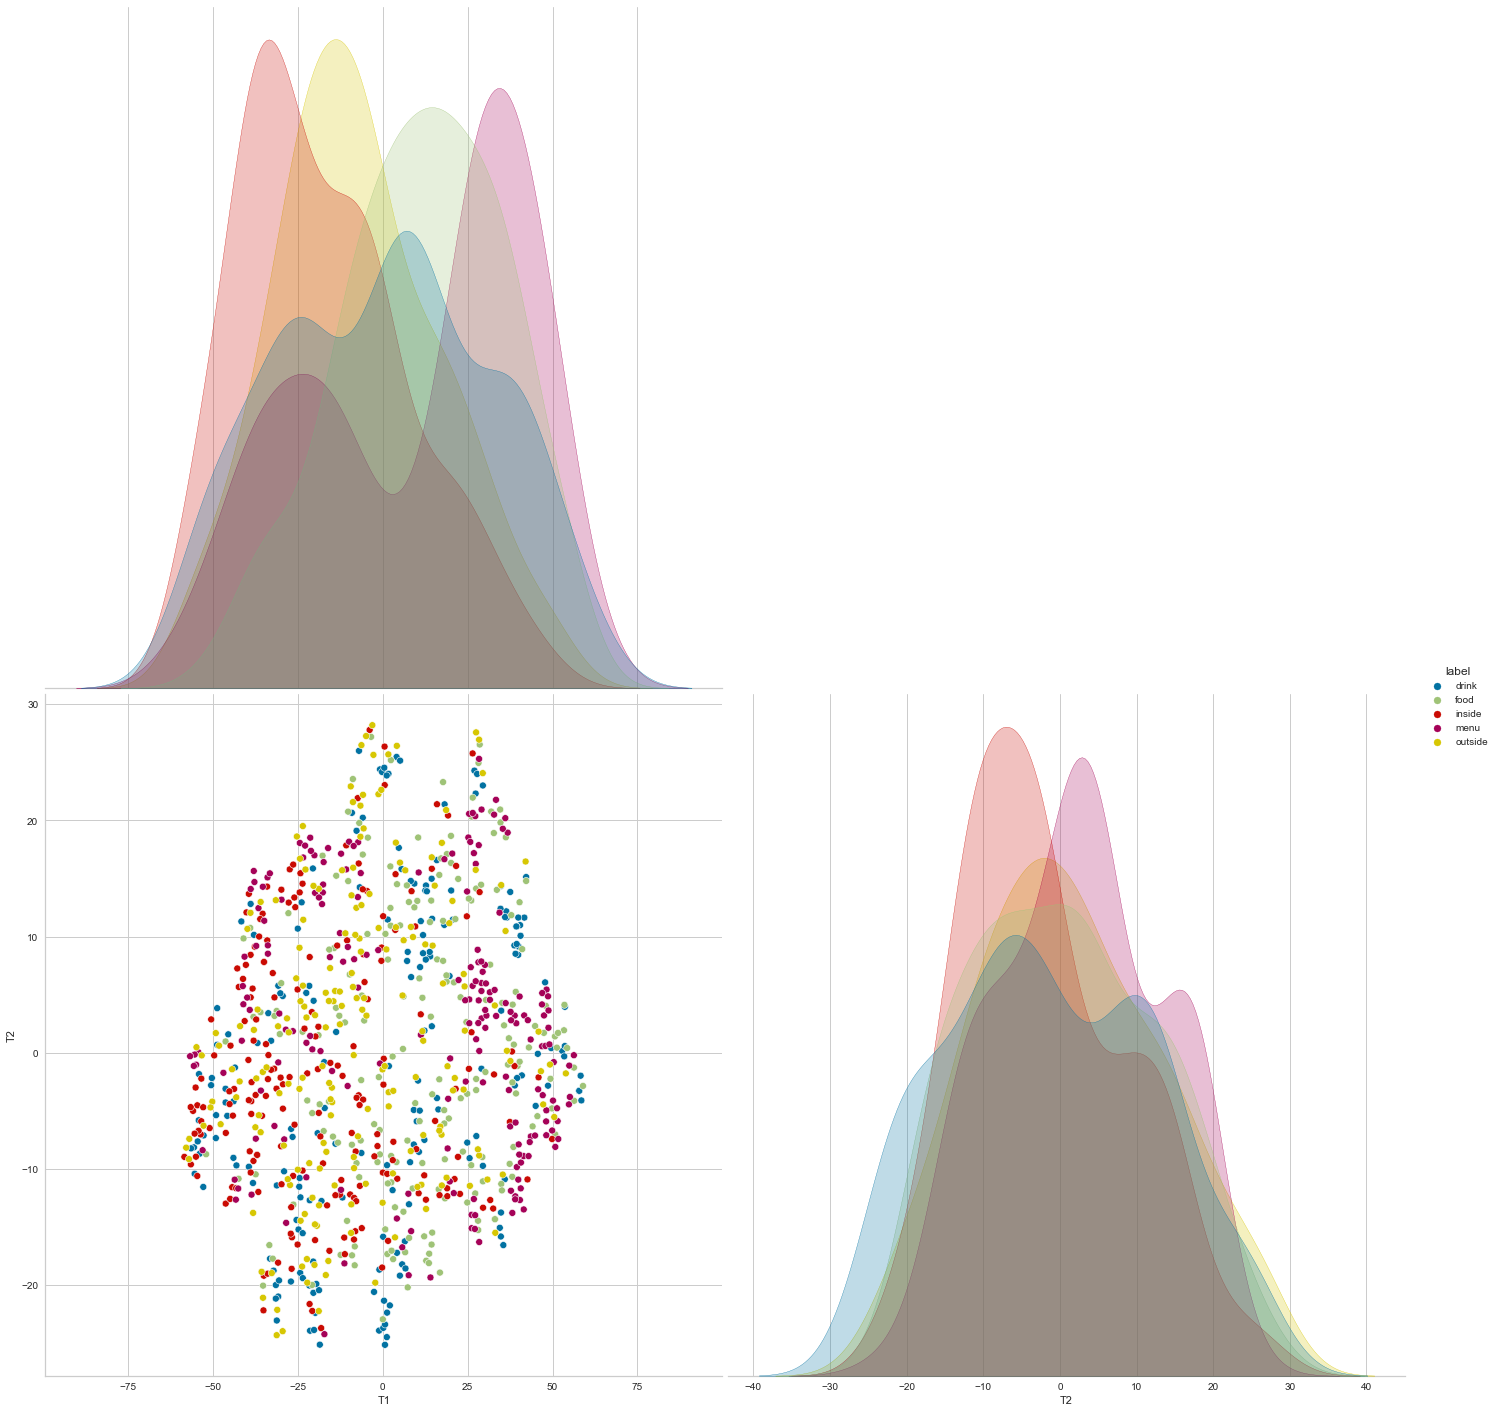

In [85]:
sns.pairplot(T_orb, size=10, corner=True, hue='label')

### Metric computation on clustering photos using ORB and SHIFT features

In [94]:
ari_metric = {}

In [95]:
from sklearn.metrics.cluster import adjusted_rand_score
kmeans_shift_pca = KMeans(n_clusters=5, random_state=1).fit(X_projected_shift)
ari_metric['ari_shift_pca'] = adjusted_rand_score(df_photos_features.label, kmeans_shift_pca.labels_)


In [96]:
kmeans_shift_tsne = KMeans(n_clusters=5, random_state=1).fit(T_shift[['T1','T2']])
ari_metric['ari_shift_tsne'] = adjusted_rand_score(df_photos_features.label, kmeans_shift_tsne.labels_)

In [97]:
kmeans_orb_pca = KMeans(n_clusters=5, random_state=1).fit(X_projected_orb)
ari_metric['ari_orb_pca'] = adjusted_rand_score(df_photos_features.label, kmeans_orb_pca.labels_)

In [98]:
kmeans_orb_tsne = KMeans(n_clusters=5, random_state=1).fit(T_orb[['T1','T2']])
ari_metric['ari_orb_tsne'] = adjusted_rand_score(df_photos_features.label, kmeans_orb_tsne.labels_)

In [99]:
ari_metric

{'ari_shift_pca': 0.12443246667924797,
 'ari_shift_tsne': 0.10121979928279368,
 'ari_orb_pca': 0.0441680585783754,
 'ari_orb_tsne': 0.042284790160085434}

In [90]:
from sklearn.neighbors import KNeighborsClassifier

pca = decomposition.PCA(n_components=n_comp_shift, random_state=10)
pca.fit(X_train_shift)

X_train_projected = pca.transform(X_train_shift)
X_train_projected = pd.DataFrame(X_train_projected, columns = ['F{0}'.format(i) for i in range(n_comp_shift)])

X_test_projected = pca.transform(X_test_shift)
X_test_projected = pd.DataFrame(X_test_projected, columns = ['F{0}'.format(i) for i in range(n_comp_shift)])


knn = KNeighborsClassifier(n_jobs=-1).fit(X_train_projected, y_train_shift)

y_train_pred = knn.predict(X_train_projected)
y_test_pred = knn.predict(X_test_projected)

In [91]:
from sklearn.metrics import plot_confusion_matrix, classification_report


print(classification_report(y_train_shift, y_train_pred))

              precision    recall  f1-score   support

       drink       0.52      0.69      0.59       150
        food       0.63      0.70      0.66       150
      inside       0.56      0.59      0.57       150
        menu       0.83      0.71      0.77       150
     outside       0.63      0.43      0.51       150

    accuracy                           0.62       750
   macro avg       0.63      0.62      0.62       750
weighted avg       0.63      0.62      0.62       750



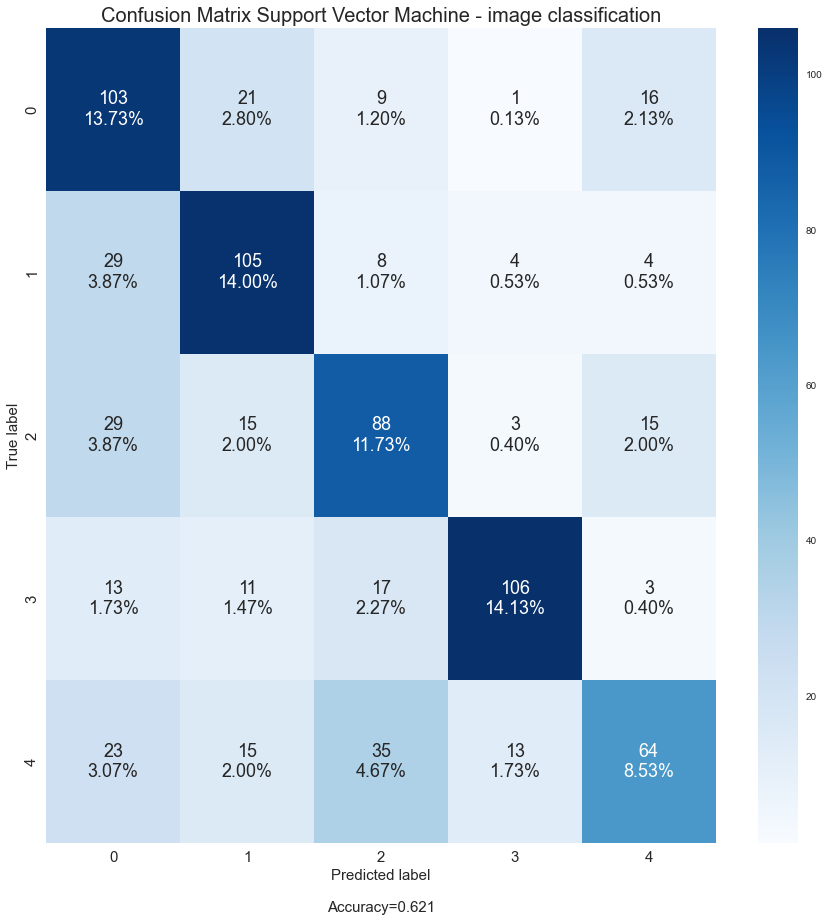

In [92]:
make_confusion_matrix(confusion_matrix(y_train_shift, y_train_pred), figsize=(15, 15), title='Confusion Matrix Support Vector Machine - image classification')

## Feature creation by transfer learning

### Creation dataset

In [111]:
# using the vgg16 model as a feature extraction model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model


df_photos_features_vgg = pd.DataFrame()

dim = (224, 224) #(128, 128)
if os.path.exists("data/processed/df_photos_features_vgg.pkl.gz"):
    logger.info(">>> Loading image vgg from pickle file...")
    df_photos_features_vgg = pd.read_pickle("data/processed/df_photos_features_vgg.pkl.gz")
    logger.info(f">>> OK : {len(df_photos_features_vgg)} images vgg loaded from pickle file.")
else:
    for photo in df_photos.itertuples():
        # Load image
        img_path = 'data/yelp_photos/photos/{0}.jpg'.format(photo.photo_id)

        #img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
        img = load_img(img_path, target_size=dim)

        #img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
        #print(img.shape) (128, 128, 3)

        # convert the image pixels to a numpy array
        img = img_to_array(img)

        # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        # prepare the image for the VGG model
        img = preprocess_input(img)


        # load model
        model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
        for layer in model.layers:
            layer.trainable = False
        # remove the output layer
        model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
        # get extracted features
        features = model.predict(img).flatten()


        dict_to_add = {"file_name": photo.photo_id, "label": photo.label, "vgg_features": features}
        df_photos_features_vgg = df_photos_features_vgg.append(dict_to_add,ignore_index=True)

        df_photos_features_vgg.dropna(inplace=True)
        
    logger.info(">>> Saving images vgg obtained data as pickle file...")
    os.makedirs("data/processed/", exist_ok=True)
    df_photos_features_vgg.to_pickle("data/processed/df_photos_features_vgg.pkl.gz")
    logger.info(
        ">>> OK : Images vgg data saved to data/processed/df_photos_features_vgg.pkl.gz ."
    )
    

INFO:__main__:>>> Loading image vgg from pickle file...
INFO:__main__:>>> OK : 1000 images vgg loaded from pickle file.


In [112]:
df_photos_features_vgg

file_name    label  \
0    vkr8T0scuJmGVvN2HJelEA    drink   
1    VYP7IZ8SjyRLM1II5WcKew    drink   
2    pRnGI7xv7ZBJ8p_w0xy9fg    drink   
3    Iehiw_bcHnXw-pg0w2M06w    drink   
4    1q1aIcuJMdeTt8QEyXFIeQ    drink   
..                      ...      ...   
995  KNbz5zsstJPTJPFv1mHB7A  outside   
996  I8MB8apJpblh_im2RwlYqQ  outside   
997  IvVt3OjgZ3fNhpMvxQ18DQ  outside   
998  IhfNzqhFHW35S5NtxpMvxg  outside   
999  ZajtbxKeDG1O00_P2lB3-Q  outside   

                                          vgg_features  
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1    [0.0, 0.0, 0.0, 0.0, 34.434727, 0.0, 0.0, 0.0,...  
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4    [0.0, 0.0, 0.0, 24.407951, 0.0, 0.0, 0.0, 25.1...  
..                                                 ...  
995  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
996  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
997  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
998  [0.0, 15.31043, 0.0, 0.0, 20.303211, 0.0, 0.0,...  
999  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[1000 rows x 3 columns]

In [113]:
#vgg_features = np.array([
#    vgg for vgg_feature in df_photos_features_vgg.vgg_features for vgg in vgg_feature
#])
vgg_features = np.array([
    vgg_feature for vgg_feature in df_photos_features_vgg.vgg_features
])

In [114]:
vgg_features.shape

(1000, 100352)

In [115]:
from sklearn.preprocessing import MinMaxScaler
vgg_features_scaler = StandardScaler().fit(vgg_features) #MinMaxScaler().fit(vgg_features) #  # RobustScaler().fit(vgg_features)
vgg_features_std = vgg_features_scaler.transform(vgg_features)
vgg_features_std = pd.DataFrame(vgg_features_std, columns = ['vgg_{0}'.format(i) for i in range(vgg_features_std.shape[1])])

In [116]:
vgg_features_std.shape

(1000, 100352)

### Dimension reduction

In [117]:
pca_features_ratio = {}
explained_by_pca = 0.40
is_not_selected=True

pca = PCA(random_state=10)
pca.fit(vgg_features_std)

for k in range(min(vgg_features_std.shape[0],vgg_features_std.shape[1]) ):
    s = np.cumsum(pca.explained_variance_ratio_)[k]
    pca_features_ratio[k] = s
    if ((s>=explained_by_pca) & is_not_selected):
        n_comp = k
        is_not_selected = False

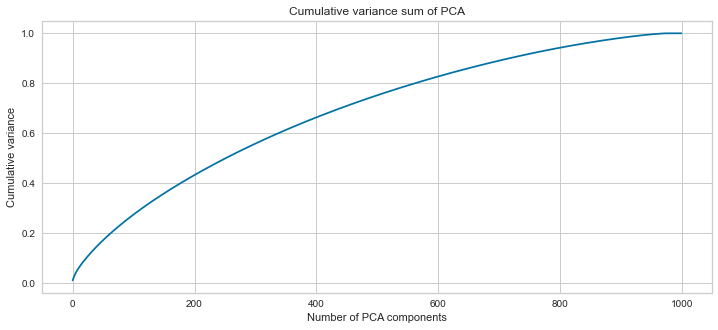

In [118]:
plt.figure(figsize=(12,5));
plt.title('Cumulative variance sum of PCA');
plt.xlabel('Number of PCA components');
plt.ylabel('Cumulative variance');
plt.plot(list(range(min(vgg_features_std.shape[0],vgg_features_std.shape[1]))),
np.cumsum(pca.explained_variance_ratio_), '-x');

In [119]:
n_comp

178

### Data visualization with PCA

In [144]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=n_comp, random_state=10)
pca.fit(vgg_features_std)

vgg_features_projected = pca.transform(vgg_features_std)
vgg_features_projected = pd.DataFrame(vgg_features_projected, columns = ['F{0}'.format(i) for i in range(n_comp)])

vgg_features_projected.loc[:,'label'] = y

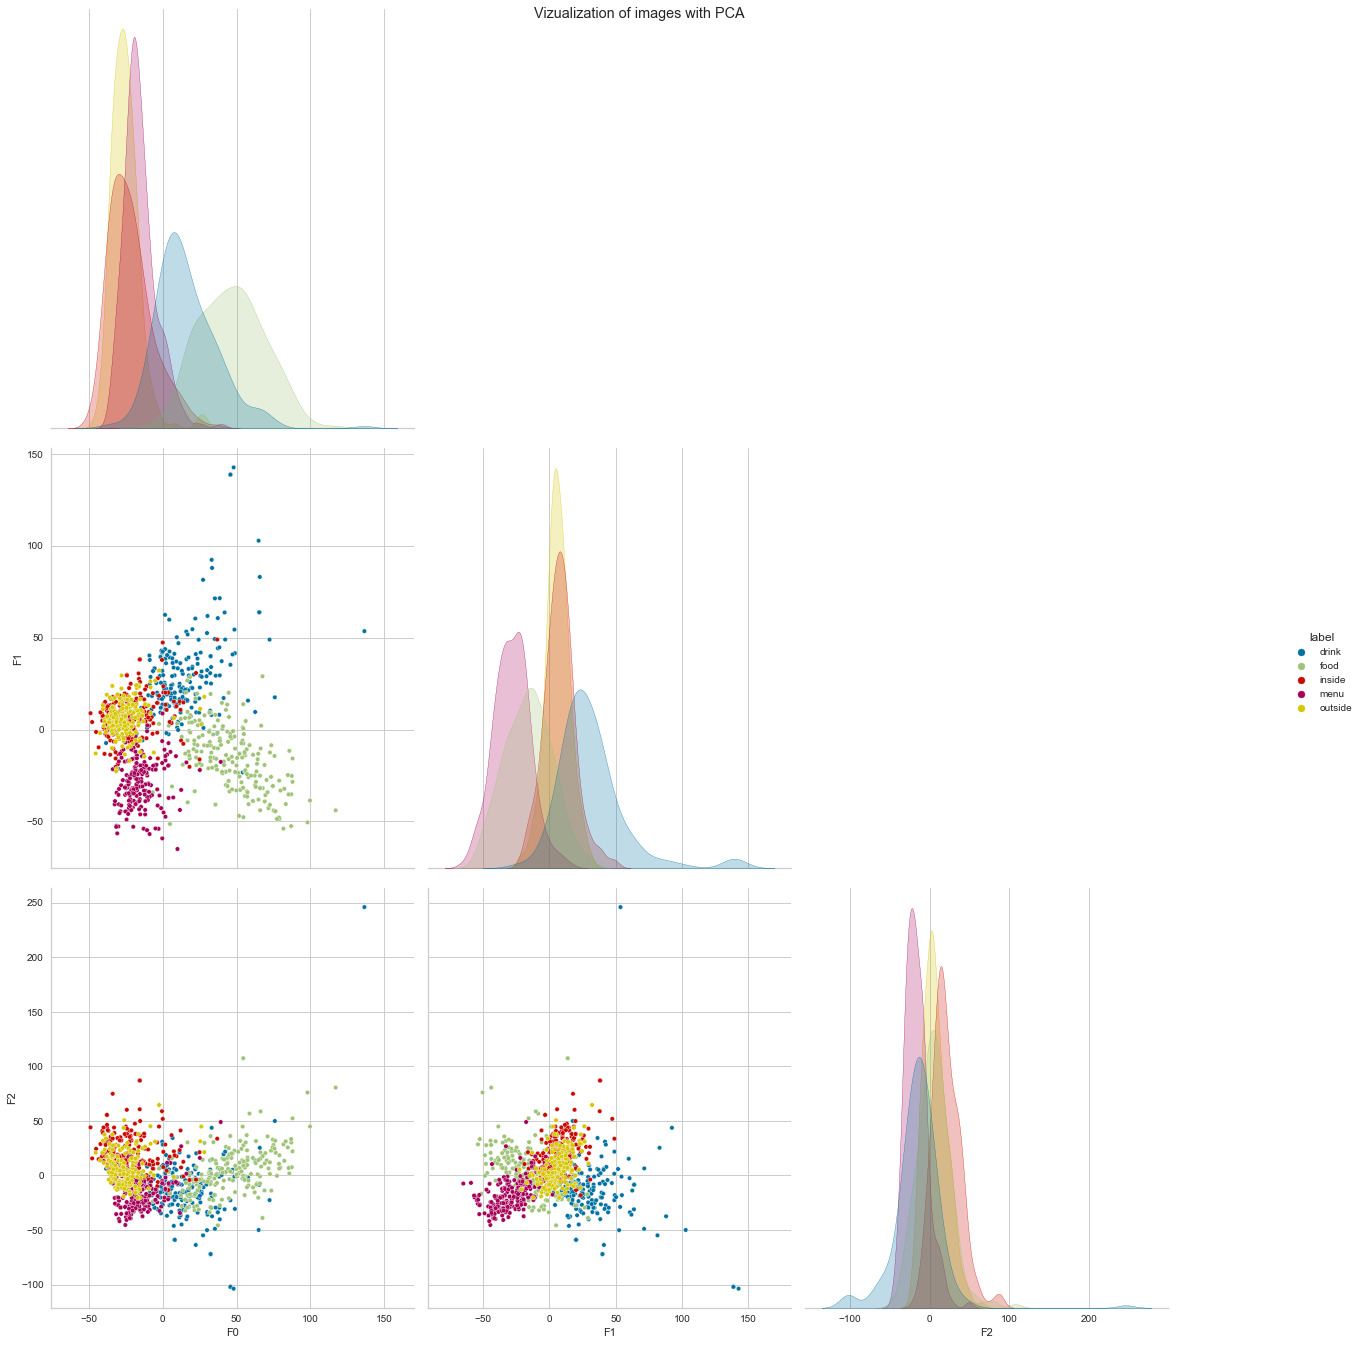

In [152]:
N = 3
to_plot = vgg_features_projected.iloc[: , :N]
to_plot.loc[:,'label'] = y
g=sns.pairplot(to_plot, plot_kws = {'s': 20}, corner=True, hue='label')
g.fig.set_size_inches(20,20)
g.fig.suptitle("Vizualization of images with PCA")
del to_plot
vgg_features_projected = vgg_features_projected.drop(columns=['label'])

### Data viusalization with TSNE

In [122]:
tsne = TSNE(n_components=2, init='pca', random_state=1)
T_vgg_features = tsne.fit_transform(vgg_features_projected) #vgg_features_projected)
T_vgg_features = pd.DataFrame(T_vgg_features, columns=['T1', 'T2'])

In [123]:
T_vgg_features.loc[:,'label'] = y

Text(0.5, 0.98, 'Vizualization of images with TSNE')

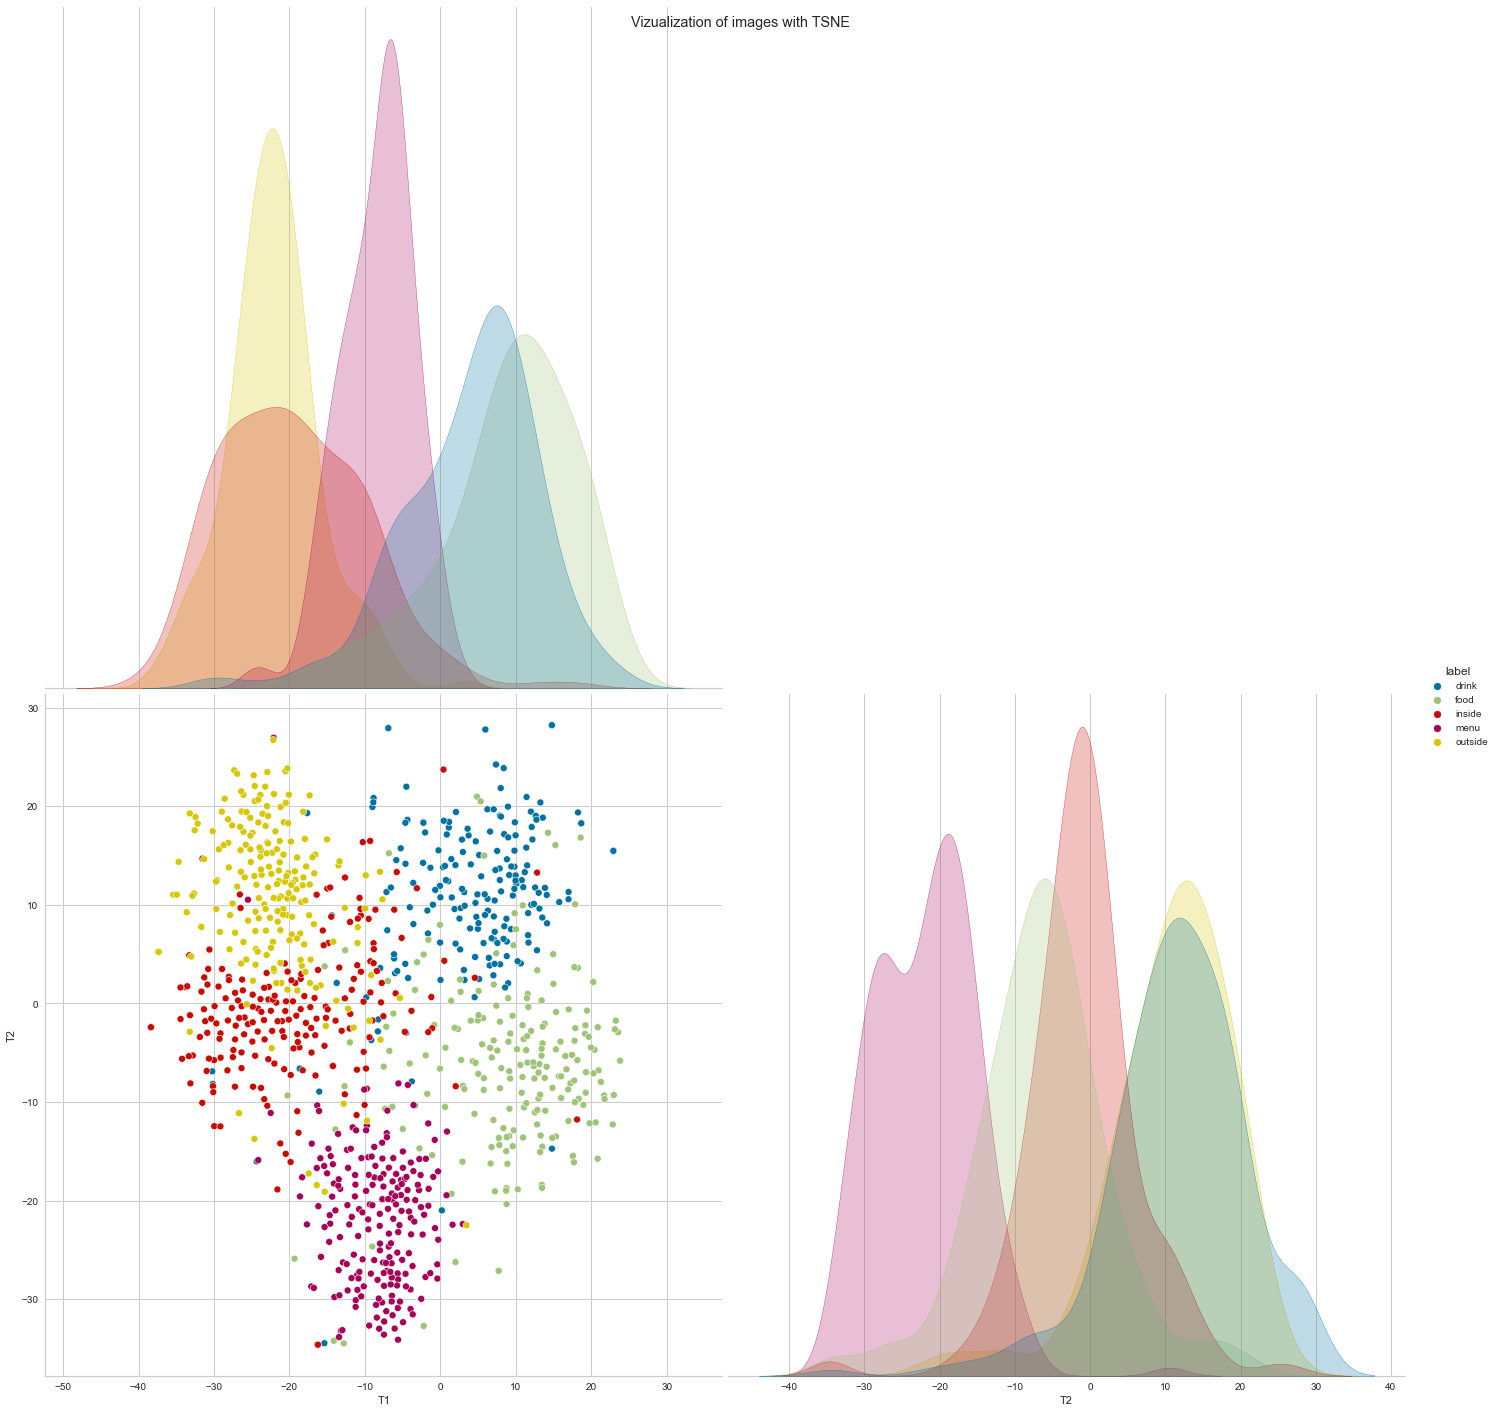

In [154]:
g=sns.pairplot(T_vgg_features, size=10, corner=True, hue='label')
g.fig.suptitle("Vizualization of images with TSNE")

### Kmeans Clustering and ARI metric computation on VGG16 features

In [129]:
kmeans_vgg_tsne = KMeans(n_clusters=5, random_state=0).fit(T_vgg_features[['T1','T2']])
ari_metric['ari_vgg_tsne'] = adjusted_rand_score(df_photos_features.label, kmeans_vgg_tsne.labels_)

In [130]:
kmeans_vgg_pca = KMeans(n_clusters=5, random_state=0).fit(vgg_features_projected)
ari_metric['ari_vgg_pca'] = adjusted_rand_score(df_photos_features.label, kmeans_vgg_pca.labels_)

In [155]:
ari_metric

{'ari_shift_pca': 0.12443246667924797,
 'ari_shift_tsne': 0.10121979928279368,
 'ari_orb_pca': 0.0441680585783754,
 'ari_orb_tsne': 0.042284790160085434,
 'ari_vgg_tsne': 0.6369244758074947,
 'ari_vgg_pca': 0.49708985447392773}

In [159]:
ari_metric = pd.DataFrame.from_dict(ari_metric, orient='index').reset_index()
ari_metric.columns=['Method', 'ARI']
ari_metric

Method       ARI
0   ari_shift_pca  0.124432
1  ari_shift_tsne  0.101220
2     ari_orb_pca  0.044168
3    ari_orb_tsne  0.042285
4    ari_vgg_tsne  0.636924
5     ari_vgg_pca  0.497090

<AxesSubplot:xlabel='Method', ylabel='ARI'>

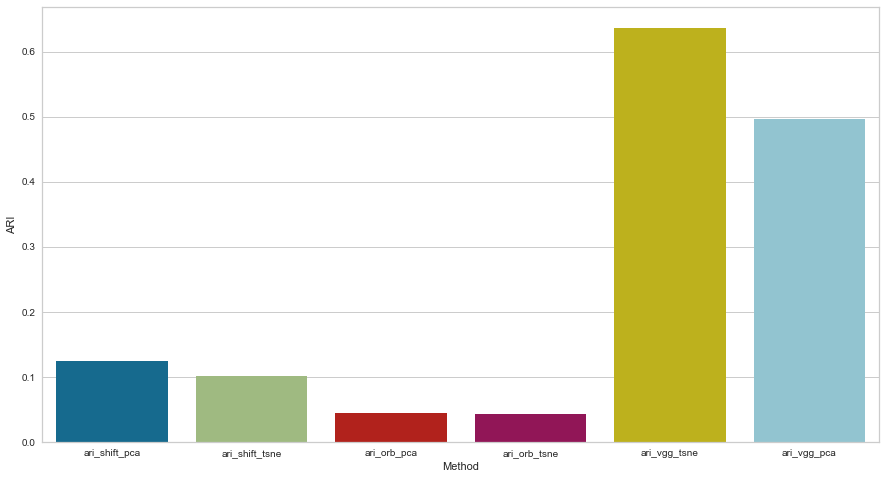

In [164]:
plt.figure(figsize=(15,8))
sns.barplot(data=ari_metric, y="ARI", x='Method')